# analyzing the effect of a constant force with an inverse powerlaw attractive force
Tim Tyree<br>
8.11.2021

In [3]:
from lib.my_initialization import *
import random,scipy
from lib.measure.compute_slope import *
from lib.measure.compute_sliding_slope import *
from lib.measure.powerlaw import *
%load_ext autoreload
%autoreload 2

from scipy import stats
alpha=0.1

In [4]:
# # For darkmode plots
# from jupyterthemes import jtplot
# jtplot.style(theme='monokai', context='notebook', ticks=True, grid=False)

# visualize the effect of turning on/off a basin of attraction

Qualitative Results from Run 13
- my kappa is too big... TODO: remeasure kappa vs. r form the full models with the FIRST time particles pass eachother
- kappa for FK should probably be smaller than kappa for LR...
- a constant repulsive force only effects the low densities
- a constant repulsive force lowers the rate particles annihilate. TODO: dev run 14 with a constant attractive force.
- a 10X factor between varkappa_LR and varkappa_FK reasonably mapped the exponents between the two models
- there is no qualitative difference between summing forces between all particles and considering forces between nearest neighbors only

In [5]:
data_dir="/home/timothytyree/Documents/GitHub/bgmc/python/data/osg_output/run_15_all.csv"
# data_dir="/home/timothytyree/Documents/GitHub/bgmc/python/data/osg_output/run_13_all.csv"
df=pd.read_csv(data_dir)
# df.head()

print(list(df.columns))

assert (not (df.CollRate<0).any())

['x0', 'varkappa', 'set_second', 'reflect', 'r', 'no_repulsion', 'no_attraction', 'niter', 'neighbor', 'kappa', 'force_code', 'dt', 'N', 'L', 'Dt', 'D', 'CollRate']


In [7]:
#derived values
# df['CollRate']=1./df['CollTime']
df['A']=df['L']**2
df['q']=df['N']/df['A'] #number of tips per square centimeter
df['w']=df['CollRate']/df['A'] #[mHz?]/cm^2

# df=df[df.niter==250].copy()
#extract column values
r_values=np.array(sorted(set(df.r.values)))#cm
D_values=np.array(sorted(set(df.D.values)))#cm^2/s
L_values=np.array(sorted(set(df.L.values)))#cm
A_values=L_values**2#cm^2
kappa_values=np.array(sorted(set(df.kappa.values)))#1/s
varkappa_values=np.array(sorted(set(df.varkappa.values)))#1/s
x0_values=np.array(sorted(set(df.x0.values)))#1/s
set_second_values=np.array(sorted(set(df.set_second.values)))
reflect_values=np.array(sorted(set(df.reflect.values)))
no_repulsion_values=np.array(sorted(set(df.no_repulsion.values)))
no_attraction_values=np.array(sorted(set(df.no_attraction.values)))
neighbor_values=np.array(sorted(set(df.neighbor.values)))
force_code_values=np.array(sorted(set(df.force_code.values)))

#make test for whether there is one input parameter present in an input DataFrame
print(f"parameters:")
print(f"r~{r_values}")
print(f"D~{D_values}")
print(f"L~{L_values}")
print(f"kappa~{kappa_values}")
print(f"a~{varkappa_values}")
print(f"x0~{x0_values}")
print(f"set_second~{set_second_values}")
print(f"reflect~{reflect_values}")
print(f"no_repulsion~{no_repulsion_values}")
print(f"no_attraction~{no_attraction_values}")
print(f"neighbor~{neighbor_values}")
print(f"force_code~{force_code_values}")

fixed parameters:
r~[0.05 0.1  0.15 0.2  0.3  0.4  0.5 ]
D~[0.7 0.8 0.9 1.  1.1 1.2 1.3 1.4 1.5 1.6 1.7 1.8 1.9 2. ]
L~[10]
kappa~[250 500]
a~[  0   1   2   3   4   5   6   7   8   9  10  15  20  25  30  35  40  45
  50  60  70  80  90 100 110]
x0~[0]
set_second~[0]
reflect~[0 1]
no_repulsion~[0]
no_attraction~[0]
neighbor~[0]
force_code~[2]


In [215]:
#for FK model
#query the control
varkappa=varkappa_values[-6] #cm^2/s
D=D_values[3]#-1]
r=r_values[0]
L=L_values[0]
set_second=0
no_repulsion=0
no_attraction=0
reflect=0
neighbor=1
force_code=4

x0=x0_values[-1]        #cm
#query the DataFrame
query =(df.set_second==set_second)&(df.reflect==reflect)
query&=df.r==r
query&=df.D==D
query&=df.L==L
query&=df.varkappa==varkappa
query&=df.x0==x0
query&=(df.no_repulsion==no_repulsion)&(df.no_attraction==no_attraction)
query&=(df.neighbor==neighbor)&(df.force_code==force_code)
dg=df[query]
kappa_values=np.array(sorted(set(dg.kappa.values)))

kappa=kappa_values[0]
dh=dg[dg.kappa==kappa]
x_values=dh.q.values
y_values=dh.w.values
x_values_control=x_values.copy()
y_values_control=y_values.copy()

x0=x0_values[0]        #cm
#query the DataFrame
query =(df.set_second==set_second)&(df.reflect==reflect)
query&=df.r==r
query&=df.D==D
query&=df.L==L
query&=df.varkappa==varkappa
query&=df.x0==x0
query&=(df.no_repulsion==no_repulsion)&(df.no_attraction==no_attraction)
query&=(df.neighbor==neighbor)&(df.force_code==force_code)
dg=df[query]

# kappa_values=np.array(sorted(set(dg.kappa.values)))
# kappa=kappa_values[1]
dh=dg[dg.kappa==kappa]
x_values=dh.q.values
y_values=dh.w.values
x_values_test=x_values.copy()
y_values_test=y_values.copy()
print((r,D,L,kappa,varkappa,x0))

(0.1, 25.0, 5, 1013.58, 50, 1.5)


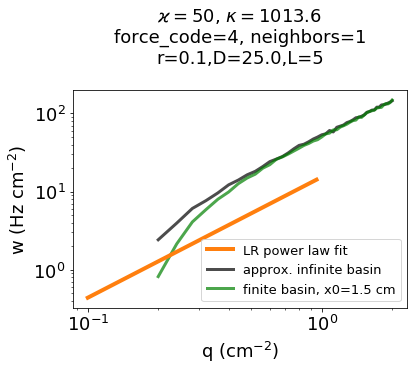

In [216]:
#plot fits for full model
m_fk=1.945;#+-0.030; B_fk=2.441+-0.051
m_lr=1.544;#+-0.034; B_lr=5.870+-0.137
M_fk=5.67;#+-0.39 Hz*cm^{2(m-1)}
M_lr=15.37;#+-1.57 Hz*cm^{2(m-1)}
# RMSE_fk=0.1252 Hz/cm^2
# RMSE_lr=0.0974 Hz/cm^2
# R^2=0.997 (FK)
# R^2=0.994 (LR)
# yscale=10**3
xv=np.arange(0.1,1.,.05)
yv_fk=M_fk*(xv)**m_fk
yv_lr=M_lr*(xv)**m_lr

fontsize=16
# plt.xlim([0.1,1])
# plt.ylim([1e-1,15])
plt.yscale('log')
plt.xscale('log')
# plt.plot(xv,yv_fk,label='FK power law fit',zorder=3,lw=4)
plt.plot(xv,yv_lr,label='LR power law fit',zorder=3,lw=4,color='C1')

fontsize=18
plt.plot(x_values_control,y_values_control,'-',c='k',alpha=.7,label=r'approx. infinite basin',lw=3)
plt.plot(x_values_test,y_values_test,'-',c='g',alpha=.7,label=f'finite basin, x0={x0:.1f} cm',lw=3)

# plt.plot(x_values,y_values,c='C2',alpha=.7,label='simulation',lw=6)
# plt.plot(x_values_force,y_values_force,c='C3',alpha=.7,label='simulation with forces',lw=6)
# plt.plot(x_values,y_values,c=c_values,alpha=0.4,cmap='bwr')
# plt.title(u'comparison to simulation\nwith two hybrid modes',fontsize=fontsize)
plt.xlabel(r'q (cm$^{-2}$)',fontsize=fontsize)
plt.ylabel(r'w (Hz cm$^{-2}$)', fontsize=fontsize)
plt.tick_params(axis='both', which='major', labelsize=fontsize)
plt.tick_params(axis='both', which='minor', labelsize=0)
plt.legend(fontsize=fontsize-5)
# plt.xlim([0.08,1])
# print(f'varkappa={varkappa}  Hz');print(f'      x0={x0} cm')
# plt.title(r'$\varkappa=$'+f'{varkappa}  Hz, '+r'$x_0=$'+f'{x0} cm\nforce_code={force_code}, neighbors={neighbor}\n',fontsize=fontsize)
plt.title(r'$\varkappa=$'+f'{varkappa}, '+r'$\kappa=$'+f'{kappa:.1f}\nforce_code={force_code}, neighbors={neighbor}\nr={r},D={D},L={L}\n',fontsize=fontsize)
plt.show()

In [173]:
#for FK model
#query the control
varkappa=varkappa_values[0] #cm^2/s
D=D_values[1]#0]#-2]
r=r_values[0]
L=L_values[0]
set_second=0
no_repulsion=0
no_attraction=0
reflect=0
neighbor=0
force_code=4

x0=x0_values[-1]        #cm
#query the DataFrame
query =(df.set_second==set_second)&(df.reflect==reflect)
query&=df.r==r
query&=df.D==D
query&=df.L==L
query&=df.varkappa==varkappa
query&=df.x0==x0
query&=(df.no_repulsion==no_repulsion)&(df.no_attraction==no_attraction)
query&=(df.neighbor==neighbor)&(df.force_code==force_code)
dg=df[query]
kappa_values=np.array(sorted(set(dg.kappa.values)))

kappa=kappa_values[0]
dh=dg[dg.kappa==kappa]
x_values=dh.q.values
y_values=dh.w.values
x_values_control=x_values.copy()
y_values_control=y_values.copy()

x0=x0_values[0]        #cm
#query the DataFrame
query =(df.set_second==set_second)&(df.reflect==reflect)
query&=df.r==r
query&=df.D==D
query&=df.L==L
query&=df.varkappa==varkappa
query&=df.x0==x0
query&=(df.no_repulsion==no_repulsion)&(df.no_attraction==no_attraction)
query&=(df.neighbor==neighbor)&(df.force_code==force_code)
dg=df[query]

kappa_values=np.array(sorted(set(dg.kappa.values)))
kappa=kappa_values[0]
dh=dg[dg.kappa==kappa]
x_values=dh.q.values
y_values=dh.w.values
x_values_test=x_values.copy()
y_values_test=y_values.copy()
print((r,D,L,kappa,varkappa,x0))

(0.1, 1.5, 5, 5127.03, 5, 1.5)


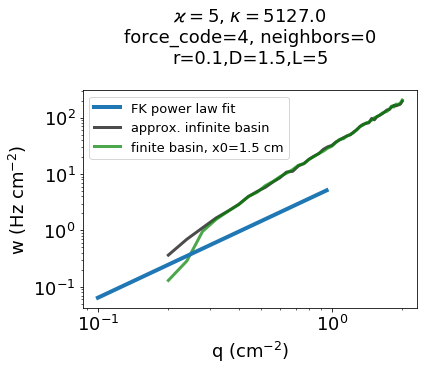

In [174]:
#plot fits for full model
m_fk=1.945;#+-0.030; B_fk=2.441+-0.051
m_lr=1.544;#+-0.034; B_lr=5.870+-0.137
M_fk=5.67;#+-0.39 Hz*cm^{2(m-1)}
M_lr=15.37;#+-1.57 Hz*cm^{2(m-1)}
# RMSE_fk=0.1252 Hz/cm^2
# RMSE_lr=0.0974 Hz/cm^2
# R^2=0.997 (FK)
# R^2=0.994 (LR)
# yscale=10**3
xv=np.arange(0.1,1.,.05)
yv_fk=M_fk*(xv)**m_fk
yv_lr=M_lr*(xv)**m_lr

fontsize=16
# plt.xlim([0.1,1])
# plt.ylim([1e-1,15])
plt.yscale('log')
plt.xscale('log')
plt.plot(xv,yv_fk,label='FK power law fit',zorder=3,lw=4)
# plt.plot(xv,yv_lr,label='LR power law fit',zorder=3,lw=4,color='C1')

fontsize=18
plt.plot(x_values_control,y_values_control,'-',c='k',alpha=.7,label=r'approx. infinite basin',lw=3)
plt.plot(x_values_test,y_values_test,'-',c='g',alpha=.7,label=f'finite basin, x0={x0:.1f} cm',lw=3)

# plt.plot(x_values,y_values,c='C2',alpha=.7,label='simulation',lw=6)
# plt.plot(x_values_force,y_values_force,c='C3',alpha=.7,label='simulation with forces',lw=6)
# plt.plot(x_values,y_values,c=c_values,alpha=0.4,cmap='bwr')
# plt.title(u'comparison to simulation\nwith two hybrid modes',fontsize=fontsize)
plt.xlabel(r'q (cm$^{-2}$)',fontsize=fontsize)
plt.ylabel(r'w (Hz cm$^{-2}$)', fontsize=fontsize)
plt.tick_params(axis='both', which='major', labelsize=fontsize)
plt.tick_params(axis='both', which='minor', labelsize=0)
plt.legend(fontsize=fontsize-5)
# plt.xlim([0.08,1])
# print(f'varkappa={varkappa}  Hz');print(f'      x0={x0} cm')
# plt.title(r'$\varkappa=$'+f'{varkappa}  Hz, '+r'$x_0=$'+f'{x0} cm\nforce_code={force_code}, neighbors={neighbor}\n',fontsize=fontsize)
plt.title(r'$\varkappa=$'+f'{varkappa}, '+r'$\kappa=$'+f'{kappa:.1f}\nforce_code={force_code}, neighbors={neighbor}\nr={r},D={D},L={L}\n',fontsize=fontsize)
plt.show()

## (skip) plot token trials for long range 1/r forces

In [414]:
#token long-ranged forces
# force_code_values=np.array([2,3])
# no_attraction_values=np.array([0])
# neighbor_values=np.array([0,1])
# set_second_values=np.array([0])
# varkappa_values=np.array([0.1,1.,5.,10.,20.,50.])#1/s
# x0_values=np.array([0.])#,1.0,5.0])#cm #x0 does nothing for QED2,3
kappa=1500;no_attraction=0;force_code=2;neighbor=0;varkappa=50;x0=0.
#query the DataFrame
query =(df.set_second==set_second)&(df.reflect==reflect)
query&=df.r==r
query&=df.D==D
query&=df.L==L
query&=df.kappa==kappa
query&=df.varkappa==varkappa
query&=df.x0==x0
query&=(df.no_repulsion==no_repulsion)&(df.no_attraction==no_attraction)
query&=(df.neighbor==neighbor)&(df.force_code==force_code)
dg=df[query]
x_values=dg.q.values
y_values=dg.w.values
x_values_force_1500=x_values.copy()
y_values_force_1500=y_values.copy()

kappa=500;
#query the DataFrame
query =(df.set_second==set_second)&(df.reflect==reflect)
query&=df.r==r
query&=df.D==D
query&=df.L==L
query&=df.kappa==kappa
query&=df.varkappa==varkappa
query&=df.x0==x0
query&=(df.no_repulsion==no_repulsion)&(df.no_attraction==no_attraction)
query&=(df.neighbor==neighbor)&(df.force_code==force_code)
dg=df[query]
x_values=dg.q.values
y_values=dg.w.values
x_values_force_500=x_values.copy()
y_values_force_500=y_values.copy()

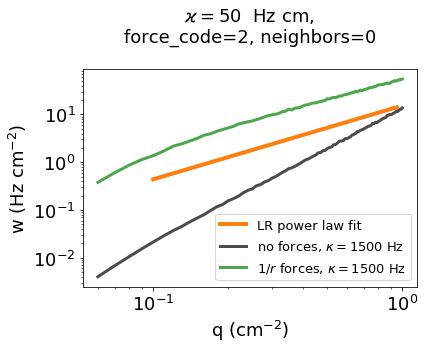

In [415]:
#plot fits for full model
m_fk=1.945;#+-0.030; B_fk=2.441+-0.051
m_lr=1.544;#+-0.034; B_lr=5.870+-0.137
M_fk=5.67;#+-0.39 Hz*cm^{2(m-1)}
M_lr=15.37;#+-1.57 Hz*cm^{2(m-1)}
# RMSE_fk=0.1252 Hz/cm^2
# RMSE_lr=0.0974 Hz/cm^2
# R^2=0.997 (FK)
# R^2=0.994 (LR)
# yscale=10**3
xv=np.arange(0.1,1.,.05)
yv_fk=M_fk*(xv)**m_fk
yv_lr=M_lr*(xv)**m_lr

fontsize=16
# plt.xlim([0.1,1])
# plt.ylim([1e-1,15])
plt.yscale('log')
plt.xscale('log')
# plt.plot(xv,yv_fk,label='FK power law fit',zorder=3,lw=4)
plt.plot(xv,yv_lr,label='LR power law fit',zorder=3,lw=4,color='C1')

fontsize=18
# plt.plot(x_values_control_500,y_values_control_500,'-',c='k',alpha=.7,label=r'no forces, $\kappa=500$ Hz',lw=3)
plt.plot(x_values_control_1500,y_values_control_1500,'-',c='k',alpha=.7,label=r'no forces, $\kappa=1500$ Hz',lw=3)
# plt.plot(x_values_force_500,y_values_force_500,'-',c='g',alpha=.7,label=r'1/$r$ forces, $\kappa=500$ Hz',lw=3)
plt.plot(x_values_force_1500,y_values_force_1500,'-',c='g',alpha=.7,label=r'1/$r$ forces, $\kappa=1500$ Hz',lw=3)

# plt.plot(x_values,y_values,c='C2',alpha=.7,label='simulation',lw=6)
# plt.plot(x_values_force,y_values_force,c='C3',alpha=.7,label='simulation with forces',lw=6)
# plt.plot(x_values,y_values,c=c_values,alpha=0.4,cmap='bwr')
# plt.title(u'comparison to simulation\nwith two hybrid modes',fontsize=fontsize)
plt.xlabel(r'q (cm$^{-2}$)',fontsize=fontsize)
plt.ylabel(r'w (Hz cm$^{-2}$)', fontsize=fontsize)
plt.tick_params(axis='both', which='major', labelsize=fontsize)
plt.tick_params(axis='both', which='minor', labelsize=0)
plt.legend(fontsize=fontsize-5)
# plt.xlim([0.08,1])
# print(f'varkappa={varkappa}  Hz');print(f'      x0={x0} cm')
plt.title(r'$\varkappa=$'+f'{varkappa}  Hz cm, '+f'\nforce_code={force_code}, neighbors={neighbor}\n',fontsize=fontsize)
plt.show()

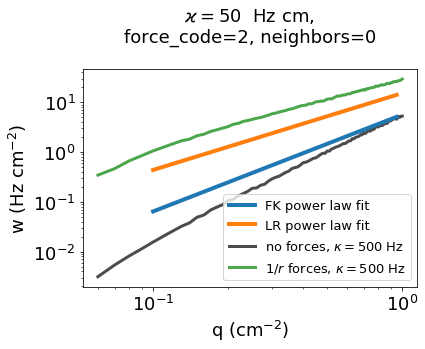

In [416]:
#plot fits for full model
m_fk=1.945;#+-0.030; B_fk=2.441+-0.051
m_lr=1.544;#+-0.034; B_lr=5.870+-0.137
M_fk=5.67;#+-0.39 Hz*cm^{2(m-1)}
M_lr=15.37;#+-1.57 Hz*cm^{2(m-1)}
# RMSE_fk=0.1252 Hz/cm^2
# RMSE_lr=0.0974 Hz/cm^2
# R^2=0.997 (FK)
# R^2=0.994 (LR)
# yscale=10**3
xv=np.arange(0.1,1.,.05)
yv_fk=M_fk*(xv)**m_fk
yv_lr=M_lr*(xv)**m_lr

fontsize=16
# plt.xlim([0.1,1])
# plt.ylim([1e-1,15])
plt.yscale('log')
plt.xscale('log')
plt.plot(xv,yv_fk,label='FK power law fit',zorder=3,lw=4)
plt.plot(xv,yv_lr,label='LR power law fit',zorder=3,lw=4,color='C1')

fontsize=18
plt.plot(x_values_control_500,y_values_control_500,'-',c='k',alpha=.7,label=r'no forces, $\kappa=500$ Hz',lw=3)
# plt.plot(x_values_control_1500,y_values_control_1500,'-',c='k',alpha=.7,label=r'no forces, $\kappa=1500$ Hz',lw=3)
plt.plot(x_values_force_500,y_values_force_500,'-',c='g',alpha=.7,label=r'1/$r$ forces, $\kappa=500$ Hz',lw=3)
# plt.plot(x_values_force_1500,y_values_force_1500,'-',c='g',alpha=.7,label=r'1/$r$ forces, $\kappa=1500$ Hz',lw=3)

# plt.plot(x_values,y_values,c='C2',alpha=.7,label='simulation',lw=6)
# plt.plot(x_values_force,y_values_force,c='C3',alpha=.7,label='simulation with forces',lw=6)
# plt.plot(x_values,y_values,c=c_values,alpha=0.4,cmap='bwr')
# plt.title(u'comparison to simulation\nwith two hybrid modes',fontsize=fontsize)
plt.xlabel(r'q (cm$^{-2}$)',fontsize=fontsize)
plt.ylabel(r'w (Hz cm$^{-2}$)', fontsize=fontsize)
plt.tick_params(axis='both', which='major', labelsize=fontsize)
plt.tick_params(axis='both', which='minor', labelsize=0)
plt.legend(fontsize=fontsize-5)
# plt.xlim([0.08,1])
# print(f'varkappa={varkappa}  Hz');print(f'      x0={x0} cm')
plt.title(r'$\varkappa=$'+f'{varkappa}  Hz cm, '+f'\nforce_code={force_code}, neighbors={neighbor}\n',fontsize=fontsize)
plt.show()

## (skip) plot token trials for long range 1/r^2 forces

In [408]:
#token long-ranged forces
# force_code_values=np.array([2,3])
# no_attraction_values=np.array([0])
# neighbor_values=np.array([0,1])
# set_second_values=np.array([0])
# varkappa_values=np.array([0.1,1.,5.,10.,20.,50.])#1/s
# x0_values=np.array([0.])#,1.0,5.0])#cm #x0 does nothing for QED2,3
kappa=1500;no_attraction=0;force_code=3;neighbor=0;varkappa=50;x0=0.
#query the DataFrame
query =(df.set_second==set_second)&(df.reflect==reflect)
query&=df.r==r
query&=df.D==D
query&=df.L==L
query&=df.kappa==kappa
query&=df.varkappa==varkappa
query&=df.x0==x0
query&=(df.no_repulsion==no_repulsion)&(df.no_attraction==no_attraction)
query&=(df.neighbor==neighbor)&(df.force_code==force_code)
dg=df[query]
x_values=dg.q.values
y_values=dg.w.values
x_values_force_1500=x_values.copy()
y_values_force_1500=y_values.copy()

kappa=500;
#query the DataFrame
query =(df.set_second==set_second)&(df.reflect==reflect)
query&=df.r==r
query&=df.D==D
query&=df.L==L
query&=df.kappa==kappa
query&=df.varkappa==varkappa
query&=df.x0==x0
query&=(df.no_repulsion==no_repulsion)&(df.no_attraction==no_attraction)
query&=(df.neighbor==neighbor)&(df.force_code==force_code)
dg=df[query]
x_values=dg.q.values
y_values=dg.w.values
x_values_force_500=x_values.copy()
y_values_force_500=y_values.copy()

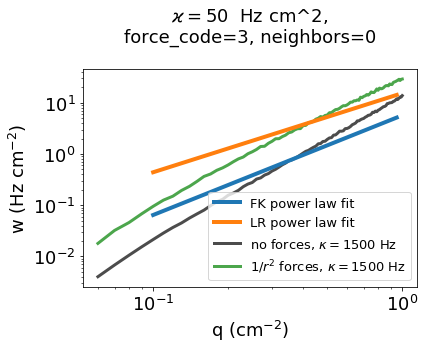

In [409]:
#plot fits for full model
m_fk=1.945;#+-0.030; B_fk=2.441+-0.051
m_lr=1.544;#+-0.034; B_lr=5.870+-0.137
M_fk=5.67;#+-0.39 Hz*cm^{2(m-1)}
M_lr=15.37;#+-1.57 Hz*cm^{2(m-1)}
# RMSE_fk=0.1252 Hz/cm^2
# RMSE_lr=0.0974 Hz/cm^2
# R^2=0.997 (FK)
# R^2=0.994 (LR)
# yscale=10**3
xv=np.arange(0.1,1.,.05)
yv_fk=M_fk*(xv)**m_fk
yv_lr=M_lr*(xv)**m_lr

fontsize=16
# plt.xlim([0.1,1])
# plt.ylim([1e-1,15])
plt.yscale('log')
plt.xscale('log')
plt.plot(xv,yv_fk,label='FK power law fit',zorder=3,lw=4)
plt.plot(xv,yv_lr,label='LR power law fit',zorder=3,lw=4,color='C1')

fontsize=18
# plt.plot(x_values_control_500,y_values_control_500,'-',c='k',alpha=.7,label=r'no forces, $\kappa=500$ Hz',lw=3)
plt.plot(x_values_control_1500,y_values_control_1500,'-',c='k',alpha=.7,label=r'no forces, $\kappa=1500$ Hz',lw=3)
# plt.plot(x_values_force_500,y_values_force_500,'-',c='g',alpha=.7,label=r'1/$r^2$ forces, $\kappa=500$ Hz',lw=3)
plt.plot(x_values_force_1500,y_values_force_1500,'-',c='g',alpha=.7,label=r'1/$r^2$ forces, $\kappa=1500$ Hz',lw=3)

# plt.plot(x_values,y_values,c='C2',alpha=.7,label='simulation',lw=6)
# plt.plot(x_values_force,y_values_force,c='C3',alpha=.7,label='simulation with forces',lw=6)
# plt.plot(x_values,y_values,c=c_values,alpha=0.4,cmap='bwr')
# plt.title(u'comparison to simulation\nwith two hybrid modes',fontsize=fontsize)
plt.xlabel(r'q (cm$^{-2}$)',fontsize=fontsize)
plt.ylabel(r'w (Hz cm$^{-2}$)', fontsize=fontsize)
plt.tick_params(axis='both', which='major', labelsize=fontsize)
plt.tick_params(axis='both', which='minor', labelsize=0)
plt.legend(fontsize=fontsize-5)
# plt.xlim([0.08,1])
# print(f'varkappa={varkappa}  Hz');print(f'      x0={x0} cm')
plt.title(r'$\varkappa=$'+f'{varkappa}  Hz cm^2, '+f'\nforce_code={force_code}, neighbors={neighbor}\n',fontsize=fontsize)
plt.show()

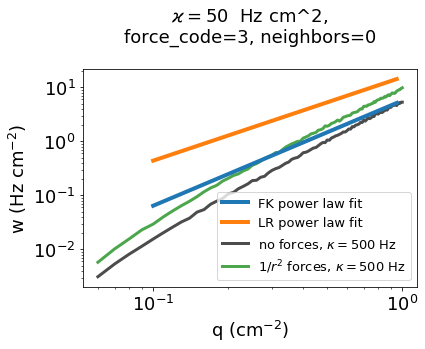

In [410]:
#plot fits for full model
m_fk=1.945;#+-0.030; B_fk=2.441+-0.051
m_lr=1.544;#+-0.034; B_lr=5.870+-0.137
M_fk=5.67;#+-0.39 Hz*cm^{2(m-1)}
M_lr=15.37;#+-1.57 Hz*cm^{2(m-1)}
# RMSE_fk=0.1252 Hz/cm^2
# RMSE_lr=0.0974 Hz/cm^2
# R^2=0.997 (FK)
# R^2=0.994 (LR)
# yscale=10**3
xv=np.arange(0.1,1.,.05)
yv_fk=M_fk*(xv)**m_fk
yv_lr=M_lr*(xv)**m_lr

fontsize=16
# plt.xlim([0.1,1])
# plt.ylim([1e-1,15])
plt.yscale('log')
plt.xscale('log')
plt.plot(xv,yv_fk,label='FK power law fit',zorder=3,lw=4)
plt.plot(xv,yv_lr,label='LR power law fit',zorder=3,lw=4,color='C1')

fontsize=18
plt.plot(x_values_control_500,y_values_control_500,'-',c='k',alpha=.7,label=r'no forces, $\kappa=500$ Hz',lw=3)
# plt.plot(x_values_control_1500,y_values_control_1500,'-',c='k',alpha=.7,label=r'no forces, $\kappa=1500$ Hz',lw=3)
plt.plot(x_values_force_500,y_values_force_500,'-',c='g',alpha=.7,label=r'1/$r^2$ forces, $\kappa=500$ Hz',lw=3)
# plt.plot(x_values_force_1500,y_values_force_1500,'-',c='g',alpha=.7,label=r'1/$r^2$ forces, $\kappa=1500$ Hz',lw=3)

# plt.plot(x_values,y_values,c='C2',alpha=.7,label='simulation',lw=6)
# plt.plot(x_values_force,y_values_force,c='C3',alpha=.7,label='simulation with forces',lw=6)
# plt.plot(x_values,y_values,c=c_values,alpha=0.4,cmap='bwr')
# plt.title(u'comparison to simulation\nwith two hybrid modes',fontsize=fontsize)
plt.xlabel(r'q (cm$^{-2}$)',fontsize=fontsize)
plt.ylabel(r'w (Hz cm$^{-2}$)', fontsize=fontsize)
plt.tick_params(axis='both', which='major', labelsize=fontsize)
plt.tick_params(axis='both', which='minor', labelsize=0)
plt.legend(fontsize=fontsize-5)
# plt.xlim([0.08,1])
# print(f'varkappa={varkappa}  Hz');print(f'      x0={x0} cm')
plt.title(r'$\varkappa=$'+f'{varkappa}  Hz cm^2, '+f'\nforce_code={force_code}, neighbors={neighbor}\n',fontsize=fontsize)
plt.show()

In [158]:
#slice relevant particle density to the particle densities observed from the full model
L=L_values[0]
# x_values=x_values_force_500#dg[dg.L==L].q.values
# y_values=y_values_force_500#dg[dg.L==L].w.values
x_values=x_values_spring_1500#dg[dg.L==L].q.values
y_values=y_values_spring_1500#dg[dg.L==L].w.values
qmin=0.06;qmax=0.6
boo=(x_values>qmin)&(x_values<qmax)
dict_ci=compute_95CI_ols(np.log(x_values[boo]),np.log(y_values[boo]))
print(*dict_ci)
print(*dict_ci.values())
print(f"Therefore, 95% confidence interval DOES include exponent values observed from the Luo-Rudy model, but for this trial, only low densities.")

m Delta_m b Delta_b Rsquared
2.2061080037818326 0.022902019300985066 3.2420266286378903 0.031409788176236186 0.9986278301835647
Therefore, 95% confidence interval DOES include exponent values observed from the Luo-Rudy model, but for this trial, only low densities.


In [159]:
#compute sliding m
xavg_values,slope_values,Rsquared_values = compute_sliding_slope_loglog(x_values,y_values,    
    x_min=qmin,
    window_width=0.2,
    stepsize=0.01,
)
xavg_values.shape

(74,)

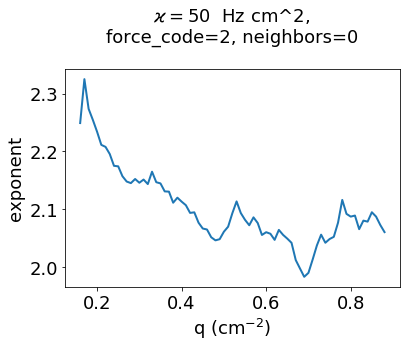

In [160]:
fontsize=18
x=xavg_values[:-1]
# y=Rsquared_values[:-1]
y=slope_values[:-1]
plt.plot(x,y,lw=2)
# plt.scatter(x,y,s=10)
# plt.xlabel('N',fontsize=fontsize)
# plt.ylabel('Collision Rate',fontsize=fontsize)
# plt.xscale('log')
# plt.title(u'comparison to simulation\nwith two hybrid modes',fontsize=fontsize)
plt.xlabel(r'q (cm$^{-2}$)',fontsize=fontsize)
plt.ylabel(r'exponent', fontsize=fontsize)
plt.tick_params(axis='both', which='major', labelsize=fontsize)
plt.tick_params(axis='both', which='minor', labelsize=0)
# print(f'varkappa={varkappa}  Hz');print(f'      x0={x0} cm')
plt.title(r'$\varkappa=$'+f'{varkappa}  Hz cm^2, '+f'\nforce_code={force_code}, neighbors={neighbor}\n',fontsize=fontsize)
plt.show()

# (skip) print powerlaw fits

In [31]:
def slice_df_and_print_powerlaw_fit(r,D,L,kappa,varkappa,x0,q_min=0.06,q_max=.2,no_attraction=0,no_repulsion=1,force_code=2):
    '''map from trial to power law fit in interval q_min to q_max'''
    #query the DataFrame
    query =(df.set_second==set_second_values[0])&(df.reflect==reflect_values[0])
    query&=df.r==r#r_values[0]
    query&=df.D==D#D_values[0]
    query&=df.L==L#L_values[0]
    query&=df.kappa==kappa
    query&=df.varkappa==varkappa#_values#[-1]#5]
    query&=df.x0==x0#_values[2]
    query&=(df.no_repulsion==no_repulsion)&(df.no_attraction==no_attraction)
    dff=df[query]
    dg=dff.copy()#[dff.kappa==kappa]#kappa_values[0]]#smaller reaction rate

    x_values=dg.q.values
    y_values=dg.w.values

    # q_min=0.1;q_max=.4
    # boo=(x_values>q_min)&(x_values<q_max)
    # x=np.log(x_values[boo])
    # y=np.log(y_values[boo])
    # dict_out=compute_95CI_ols(x,y)
    # dict_out
    boo=(x_values>q_min)&(x_values<q_max)
    x=x_values[boo]
    y=y_values[boo]
#     print(x)
    print_fit_power_law(x,y)

In [16]:
varkappa=varkappa_values[-1]
x0=x0_values[2]
kappa=kappa_values[0]

r=r_values[0];D=D_values[0];L=L_values[0];
slice_df_and_print_powerlaw_fit(r,D,L,kappa,varkappa,x0)

m=1.504+-0.063; B=1.263+-0.066
M= 1.42+-0.14 Hz*cm^{2(m-1)}
RMSE=0.0035 Hz/cm^2
R^2=0.995


In [17]:
# r=r_values[0];D=D_values[0];
# varkappa=varkappa_values[0]
# x0=x0_values[0]
for varkappa in varkappa_values:#[::2]:
    print(f"for r={r:.3f} cm and D={D} cm^2/s fixed,")
    print(f"the powerlaw fit for varkappa={varkappa} cm and x0={x0} was")
    try:
        slice_df_and_print_powerlaw_fit(r,D,L,kappa,varkappa,x0)
    except AssertionError as e:
        print(f"Error: empty slice!")
    print(f'')    

for r=0.100 cm and D=2 cm^2/s fixed,
the powerlaw fit for varkappa=-20 cm and x0=1.0 was
m=3.004+-0.168; B=4.158+-0.258
M= 72.26+-38.81 Hz*cm^{2(m-1)}
RMSE=0.0263 Hz/cm^2
R^2=0.991

for r=0.100 cm and D=2 cm^2/s fixed,
the powerlaw fit for varkappa=-10 cm and x0=1.0 was
m=2.831+-0.110; B=3.264+-0.130
M= 28.48+-7.90 Hz*cm^{2(m-1)}
RMSE=0.0087 Hz/cm^2
R^2=0.996

for r=0.100 cm and D=2 cm^2/s fixed,
the powerlaw fit for varkappa=-5 cm and x0=1.0 was
m=2.837+-0.097; B=2.787+-0.087
M= 18.33+-3.82 Hz*cm^{2(m-1)}
RMSE=0.0041 Hz/cm^2
R^2=0.997

for r=0.100 cm and D=2 cm^2/s fixed,
the powerlaw fit for varkappa=0 cm and x0=1.0 was
m=2.830+-0.094; B=2.241+-0.085
M= 9.82+-1.99 Hz*cm^{2(m-1)}
RMSE=0.0027 Hz/cm^2
R^2=0.997

for r=0.100 cm and D=2 cm^2/s fixed,
the powerlaw fit for varkappa=5 cm and x0=1.0 was
m=1.920+-0.073; B=1.579+-0.068
M= 2.40+-0.30 Hz*cm^{2(m-1)}
RMSE=0.0027 Hz/cm^2
R^2=0.996

for r=0.100 cm and D=2 cm^2/s fixed,
the powerlaw fit for varkappa=10 cm and x0=1.0 was
Error: empty 

__Result__
- attractive spring at with x0=0 gave $m \approx 2$... Several values are superquadratic.

In [120]:
import sys

text_fn=data_dir.replace('.csv','_powerfits.txt')
original_stdout = sys.stdout # Save a reference to the original standard output
count=0
with open(text_fn, 'w') as f:
    sys.stdout = f # Change the standard output to the file we created.
    #     r=r_values[1];D=D_values[3];
    for r in r_values:
        for D in D_values:
            for L in L_values:
                for kappa in kappa_values:
                    for varkappa in varkappa_values:
                        for x0 in x0_values:
                            for no_repulsion in no_repulsion_values:
                                for no_attraction in no_attraction_values:
                                    print(f"for r={r:.3f} cm, D={D:.3f} cm^2/s, kappa={kappa:.0f} 1/s,no_repulsion={no_repulsion==1}, and no_attraction={no_attraction==1} fixed")
                                    print(f"the powerlaw fit for varkappa={varkappa:.1f} cm and x0={x0:.1f} was")
                                    try:
                                        slice_df_and_print_powerlaw_fit(r,D,L,kappa,varkappa,x0)
                                    except AssertionError as e:
                                        print(f"Error: empty slice!")
                                    print(f'')
                                    count+=1

sys.stdout = original_stdout # Reset the standard output to its original value
print(f'output redirected to {text_fn}.')
print(f"number of trials considered = {count}")

output redirected to /home/timothytyree/Documents/GitHub/bgmc/python/data/osg_output/run_10_all_powerfits.txt.
number of trials considered = 2688


__Result__
- no trials exhibited exponent smaller than m<2.00000. 
- the robust exponents are still too large to support the LR model, which has m=1.544...

# varying varkappa

x0=10000.0
kappa=5127.0,varkappa=5.0
kappa=5127.0,varkappa=10.0
kappa=1013.6,varkappa=50.0
kappa=1013.6,varkappa=100.0


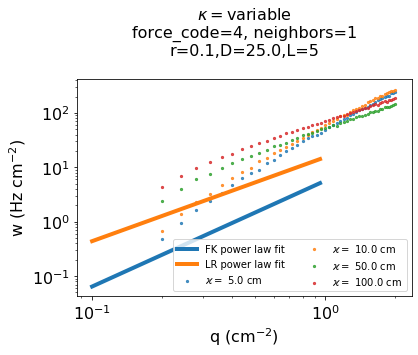

In [227]:
x0=x0_values[-1];print(f"x0={x0}")
no_repulsion=0;no_attraction=0;reflect=0;neighbors=0;set_second=0
r=r_values[0];D=D_values[-1];L=L_values[0]
#plot fits for full model
m_fk=1.945;#+-0.030; B_fk=2.441+-0.051
m_lr=1.544;#+-0.034; B_lr=5.870+-0.137
M_fk=5.67;#+-0.39 Hz*cm^{2(m-1)}
M_lr=15.37;#+-1.57 Hz*cm^{2(m-1)}
# RMSE_fk=0.1252 Hz/cm^2
# RMSE_lr=0.0974 Hz/cm^2
# R^2=0.997 (FK)
# R^2=0.994 (LR)
# yscale=10**3
xv=np.arange(0.1,1.,.05)
yv_fk=M_fk*(xv)**m_fk
yv_lr=M_lr*(xv)**m_lr

fontsize=16
# plt.xlim([0.1,1])
# plt.ylim([1e-1,15])act
plt.yscale('log')
plt.xscale('log')
plt.plot(xv,yv_fk,label='FK power law fit',zorder=3,lw=4)
plt.plot(xv,yv_lr,label='LR power law fit',zorder=3,lw=4)

#plot data
for varkappa in varkappa_values[::3]:#[:4]:#[::2]:
    #query the DataFrame
    query =(df.set_second==set_second)&(df.reflect==reflect)
    query&=df.r==r
    query&=df.D==D
    query&=df.L==L
    query&=df.varkappa==varkappa
    query&=df.x0==x0
    query&=(df.no_repulsion==no_repulsion)&(df.no_attraction==no_attraction)
    query&=(df.neighbor==neighbor)&(df.force_code==force_code)
    dg=df[query]

    kappa_values=np.array(sorted(set(dg.kappa.values)))
    kappa=kappa_values[0]
    dh=dg[dg.kappa==kappa]
    x_values=dh.q.values
    y_values=dh.w.values
    print(r'kappa='+f'{kappa:.1f},varkappa={varkappa:.1f}')
    
    
    plt.scatter(x_values,y_values,label=r"$\varkappa =$ "+f"{varkappa:.1f} cm",alpha=0.8,s=5)#,cmap='bwr')

# plt.ylim([1e-5,1e4])
plt.xlabel(r'q (cm$^{-2}$)',fontsize=fontsize)
plt.ylabel(r'w (Hz cm$^{-2}$)', fontsize=fontsize)
plt.tick_params(axis='both', which='major', labelsize=fontsize)
plt.tick_params(axis='both', which='minor', labelsize=0)
plt.legend(fontsize=fontsize-6,ncol=2,loc='lower right')
# plt.title(r'$\varkappa=$'+f'{varkappa}  Hz, '+r'$x_0=$'+f'{x0} cm\n',fontsize=fontsize)
# plt.title(r'$x_0=$'+f'{x0} cm\n',fontsize=fontsize)
# plt.title(r'$\kappa=$'+f'{kappa:.1f}\nforce_code={force_code}, neighbors={neighbor}\nr={r},D={D},L={L}\n',fontsize=fontsize)
plt.title(r'$\kappa=$'+f'variable\nforce_code={force_code}, neighbors={neighbor}\nr={r},D={D},L={L}\n',fontsize=fontsize)
plt.show()

In [231]:
q_min=0.3;q_max=2
#TODO: plot m+-Delta_m versus energy gap for LR and FK model
#plot data
kappa=kappa_values[0]
# r=1.;D=5.;Dratio=1000;L=L_values[-1]
eg_lst=[];m_lst=[];Dm_lst=[];Rsq_lst=[]
for varkappa in varkappa_values:
    try:
        #query the DataFrame
        query =(df.set_second==set_second)&(df.reflect==reflect)
        query&=df.r==r
        query&=df.D==D
        query&=df.L==L
        query&=df.varkappa==varkappa
        query&=df.x0==x0
        query&=(df.no_repulsion==no_repulsion)&(df.no_attraction==no_attraction)
        query&=(df.neighbor==neighbor)&(df.force_code==force_code)
        dg=df[query]

        kappa_values=np.array(sorted(set(dg.kappa.values)))
        kappa=kappa_values[0]
        dh=dg[dg.kappa==kappa]
        x_values=dh.q.values
        y_values=dh.w.values

        boo=(x_values>q_min)&(x_values<q_max)
        x=x_values[boo]
        y=y_values[boo]
        
        # print_fit_power_law(x,y)
        B,Delta_B,m,Delta_m,Rsq=fit_power_law(x,y)
        rmse=compute_power_rmse(x,y,m,B)
        M, Delta_M= comp_power_scale(B,Delta_B,m,Delta_m)
    #     print(f"m={m:.3f}+-{Delta_m:.3f}; B={B:.3f}+-{Delta_B:.3f}")
    #     print(f"M=B**m={M:.2f}+-{Delta_M:.2f} Hz*cm^{{2(m-1)}}")
    #     print(f"RMSE={rmse:.4f} Hz/cm^2")
    #     print(f"R^2={Rsq:.3f}")

        eg_lst.append(varkappa)
        m_lst.append(m)
        Dm_lst.append(Delta_m)
        Rsq_lst.append(Rsq)
    except AssertionError as e:
        pass
print(Rsq_lst)

[0.9980735675578696, 0.9982327915134429, 0.9982496907562921, 0.998202726304392, 0.9979102003723361, 0.9976229576711108, 0.9977539676153646, 0.9982775613427805, 0.9979115054323936, 0.9984489011627689, 0.9977881691220786, 0.9975113193034242]


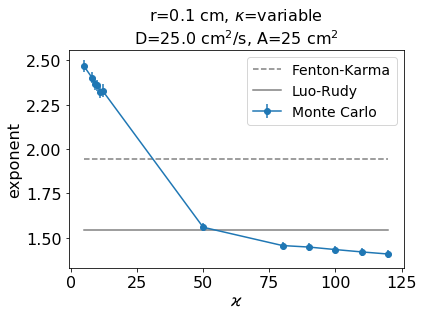

considering 0.3<q<2


In [233]:
m_fk=1.945#1.858;#+-0.027; B_fk=2.464+-0.030<br>
m_lr=1.544#1.638;#+-0.017; B_fk=5.588+-0.067
plt.errorbar(eg_lst, m_lst, yerr=Dm_lst, fmt='-o',label='Monte Carlo')
plt.plot(eg_lst, m_fk+0.*np.array(eg_lst), '--',c='gray',label='Fenton-Karma')
plt.plot(eg_lst, m_lr+0.*np.array(eg_lst), '-',c='gray',label='Luo-Rudy')

# plt.scatter(Dtdt_lst,m_lst,marker='^')
# plt.xscale('log')
# title=f"r={r:.1f} cm, "+r"$\kappa$="+f"{kappa:.0f} Hz\nD={D} cm"+r"$^2$/s"+f", A={L**2:.0f} cm"+r"$^2$"
title=f"r={r:.1f} cm, "+r"$\kappa$="+f"variable\nD={D} cm"+r"$^2$/s"+f", A={L**2:.0f} cm"+r"$^2$"
plt.title(title,fontsize=fontsize)
plt.xlabel(r'$\varkappa$',fontsize=fontsize)
plt.ylabel('exponent',fontsize=fontsize)
# plt.xscale('log')
# plt.yscale('log')
plt.tick_params(axis='both', which='major', labelsize=fontsize)
plt.tick_params(axis='both', which='minor', labelsize=0)
# plt.legend(fontsize=fontsize-8)#,ncol=2)
# plt.xlim([10,50])
# plt.ylim([0.9,2.3])
# plt.grid('on')
plt.legend(fontsize=fontsize-2)
plt.show()
# print("considering 20<N<50 spiral tips")
# print("considering N<20 spiral tips")
print(f"considering {q_min}<q<{q_max}")

# (skip) varying x0 for Case 3 of spring forces

varkappa=-20
D=20
kappa=1500


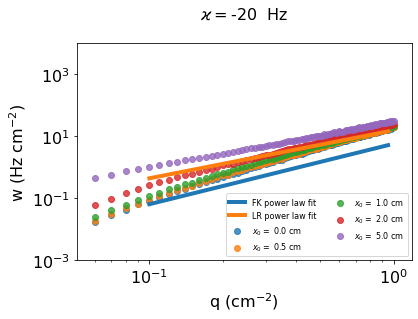

In [286]:
varkappa=varkappa_values[0];print(f'varkappa={varkappa}')
# varkappa=varkappa_values[2];print(f'varkappa={varkappa}')
r=r_values[0];
D=D_values[1];print(f'D={D}')
L=L_values[-1]
kappa_values=np.array(sorted(set(df['kappa'].values)))
kappa=kappa_values[2];print(f'kappa={kappa}')
#plot fits for full model
m_fk=1.945;#+-0.030; B_fk=2.441+-0.051
m_lr=1.544;#+-0.034; B_lr=5.870+-0.137
M_fk=5.67;#+-0.39 Hz*cm^{2(m-1)}
M_lr=15.37;#+-1.57 Hz*cm^{2(m-1)}
# RMSE_fk=0.1252 Hz/cm^2
# RMSE_lr=0.0974 Hz/cm^2
# R^2=0.997 (FK)
# R^2=0.994 (LR)
# yscale=10**3
xv=np.arange(0.1,1.,.05)
yv_fk=M_fk*(xv)**m_fk
yv_lr=M_lr*(xv)**m_lr

fontsize=16
# plt.xlim([0.1,1])
# plt.ylim([1e-1,15])
plt.yscale('log')
plt.xscale('log')
plt.plot(xv,yv_fk,label='FK power law fit',zorder=3,lw=4)
plt.plot(xv,yv_lr,label='LR power law fit',zorder=3,lw=4)

#plot data
for x0 in x0_values[[0,1,2,-4,-1]]:#[::2]:
    #query the DataFrame
    query=df.r==r
    query&=df.D==D
    query&=df.L==L
    query&=df.varkappa==varkappa
    query&=df['x0']==x0
    query&=df.kappa==kappa
    query&=(df.no_repulsion==no_repulsion)&(df.no_attraction==no_attraction)
    dff=df[query]
    dg=dff.copy()
    x_values=dg.q.values
    y_values=dg.w.values
    if x_values.shape[0]>0:
        plt.scatter(x_values,y_values,label=r"$x_0 =$ "+f"{x0:.1f} cm",alpha=0.8)#,cmap='bwr')

plt.ylim([1e-3,1e4])
plt.xlabel(r'q (cm$^{-2}$)',fontsize=fontsize)
plt.ylabel(r'w (Hz cm$^{-2}$)', fontsize=fontsize)
plt.tick_params(axis='both', which='major', labelsize=fontsize)
plt.tick_params(axis='both', which='minor', labelsize=0)
plt.title(r'$\varkappa=$'+f'{varkappa}  Hz\n',fontsize=fontsize)
plt.legend(fontsize=fontsize-8,ncol=2,loc='lower right')
plt.show()

In [287]:
# print(f"""
# the following parameter set did not tend to finish in <10 hours...
# r={r:.1f},D={D:.0f},L={L:.0f},kappa={kappa:.0f},varkappa={varkappa:.0f},x0={x0:.0f},no_attraction={no_attraction},no_repulsion={no_repulsion}
# """)

In [288]:
q_min=0.3;q_max=0.6
#TODO: plot m+-Delta_m versus energy gap for LR and FK model
#plot data
# r=1.;D=5.;Dratio=1000;L=L_values[-1]
eg_lst=[];m_lst=[];Dm_lst=[];Rsq_lst=[]
for x0 in x0_values:
    try:
        #query the DataFrame
        query=df.r==r
        query&=df.D==D
        query&=df.L==L
        query&=df.varkappa==varkappa
        query&=df['x0']==x0
        query&=df.kappa==kappa
        query&=(df.no_repulsion==no_repulsion)&(df.no_attraction==no_attraction)
        dff=df[query]
        dg=dff.copy()
        x_values=dg.q.values
        y_values=dg.w.values

        
        boo=(x_values>q_min)&(x_values<q_max)
        x=x_values[boo]
        y=y_values[boo]

        # print_fit_power_law(x,y)
        B,Delta_B,m,Delta_m,Rsq=fit_power_law(x,y)
        rmse=compute_power_rmse(x,y,m,B)
        M, Delta_M= comp_power_scale(B,Delta_B,m,Delta_m)
    #     print(f"m={m:.3f}+-{Delta_m:.3f}; B={B:.3f}+-{Delta_B:.3f}")
    #     print(f"M=B**m={M:.2f}+-{Delta_M:.2f} Hz*cm^{{2(m-1)}}")
    #     print(f"RMSE={rmse:.4f} Hz/cm^2")
    #     print(f"R^2={Rsq:.3f}")

        eg_lst.append(x0)
        m_lst.append(m)
        Dm_lst.append(Delta_m)
        Rsq_lst.append(Rsq)
    except AssertionError as e:
        pass
print(Rsq_lst)

[0.996693274038762, 0.9975654219249528, 0.9972765731672059, 0.9978175206269596, 0.9976569344715482, 0.9930568480278263, 0.9961572176751932, 0.9951628886736184]


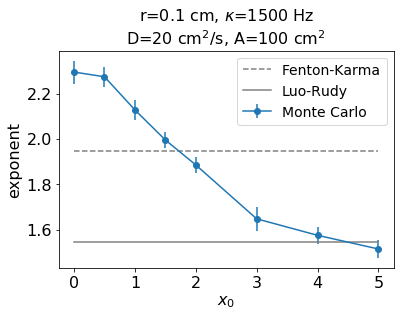

considering 0.3<q<0.6


In [289]:
m_fk=1.945#1.858;#+-0.027; B_fk=2.464+-0.030<br>
m_lr=1.544#1.638;#+-0.017; B_fk=5.588+-0.067
plt.errorbar(eg_lst, m_lst, yerr=Dm_lst, fmt='-o',label='Monte Carlo')
plt.plot(eg_lst, m_fk+0.*np.array(eg_lst), '--',c='gray',label='Fenton-Karma')
plt.plot(eg_lst, m_lr+0.*np.array(eg_lst), '-',c='gray',label='Luo-Rudy')

# plt.scatter(Dtdt_lst,m_lst,marker='^')
# plt.xscale('log')
title=f"r={r:.1f} cm, "+r"$\kappa$="+f"{kappa:.0f} Hz\nD={D} cm"+r"$^2$/s"+f", A={L**2:.0f} cm"+r"$^2$"
plt.title(title,fontsize=fontsize)
plt.xlabel(r'$x_0$',fontsize=fontsize)
plt.ylabel('exponent',fontsize=fontsize)
# plt.xscale('log')
# plt.yscale('log')
plt.tick_params(axis='both', which='major', labelsize=fontsize)
plt.tick_params(axis='both', which='minor', labelsize=0)
# plt.legend(fontsize=fontsize-8)#,ncol=2)
# plt.xlim([10,50])
# plt.ylim([0.9,2.3])
# plt.grid('on')
plt.legend(fontsize=fontsize-2)
plt.show()
# print("considering 20<N<50 spiral tips")
# print("considering N<20 spiral tips")
print(f"considering {q_min}<q<{q_max}")

__Result:__ at high densities, exponent values _versus_ $x_0$ appear relatively unaffected by increasing the overall rate of reaction, $\kappa>0$.

__Note:__ any trials that returned gibberish results seemed to have r=1.0cm...

Can I shift the overall rate (M) without changing the exponent?  So far, no.  Unless if r does it for large r.  I only look at small r here.

gibberish trials exhibited negative collision times.  
- DONT: find the point in the analysis pipeline where gibberish trials are filtered.
    - it is no-where in this .ipynb
    - DONE: check around in run_9_all/ for one trial that had CollRate<0.  
        - IF none exist, __then filter_folder.py is responsible (confirmed)__
            - ( some exist, then I can identify them quickly with a short function using pandas.)
- DONT: print ^that slice of the data.  Do they have something concerning in common?

Looking at jobs that returned gibberish:
- cat job.out.9981847.999
    - r=1,kappa=1500,all forces were off
- cat job.out.9981847.900
    - r=1,kappa=500,all forces were on
- cat job.out.9981847.900
    - r=1,kappa=500,all forces were on
    
...no trials were observed with r=1 in df

In [111]:
print(f"the set of r values are")
set(df.r.values)

the set of r values are


{0.1}

__Conclusion__
- Large r values resulted in a functional failure... Avoid large r for now.  I have observed them to be small (r~0.1cm) anyway!

# (skip) varying r for Case 3

varkappa=-10
x0=5.0
D=2
kappa=1500


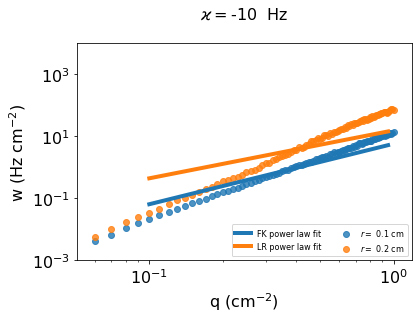

In [400]:
# varkappa=varkappa_values[3];print(f'varkappa={varkappa}')
varkappa=varkappa_values[1];print(f'varkappa={varkappa}')
# r=r_values[0];
x0 =x0_values[-1];print(f'x0={x0}')#[0,1,2,-4,-1]]:#[::2]:
D=D_values[0];print(f'D={D}')
L=L_values[-1]
kappa_values=np.array(sorted(set(df['kappa'].values)))
kappa=kappa_values[-1];print(f'kappa={kappa}')
no_attraction=1
#plot fits for full model
m_fk=1.945;#+-0.030; B_fk=2.441+-0.051
m_lr=1.544;#+-0.034; B_lr=5.870+-0.137
M_fk=5.67;#+-0.39 Hz*cm^{2(m-1)}
M_lr=15.37;#+-1.57 Hz*cm^{2(m-1)}
# RMSE_fk=0.1252 Hz/cm^2
# RMSE_lr=0.0974 Hz/cm^2
# R^2=0.997 (FK)
# R^2=0.994 (LR)
# yscale=10**3
xv=np.arange(0.1,1.,.05)
yv_fk=M_fk*(xv)**m_fk
yv_lr=M_lr*(xv)**m_lr

fontsize=16
# plt.xlim([0.1,1])
# plt.ylim([1e-1,15])
plt.yscale('log')
plt.xscale('log')
plt.plot(xv,yv_fk,label='FK power law fit',zorder=3,lw=4)
plt.plot(xv,yv_lr,label='LR power law fit',zorder=3,lw=4)

#plot data
for r in r_values:
    #query the DataFrame
    query=df.r==r
    query&=df.D==D
    query&=df.L==L
    query&=df.varkappa==varkappa
    query&=df['x0']==x0
    query&=df.kappa==kappa
    query&=(df.no_repulsion==no_repulsion)&(df.no_attraction==no_attraction)
    dff=df[query]
    dg=dff.copy()
    x_values=dg.q.values
    y_values=dg.w.values
    if x_values.shape[0]>0:
        plt.scatter(x_values,y_values,label=r"$r=$ "+f"{r:.1f} cm",alpha=0.8)#,cmap='bwr')

plt.ylim([1e-3,1e4])
plt.xlabel(r'q (cm$^{-2}$)',fontsize=fontsize)
plt.ylabel(r'w (Hz cm$^{-2}$)', fontsize=fontsize)
plt.tick_params(axis='both', which='major', labelsize=fontsize)
plt.tick_params(axis='both', which='minor', labelsize=0)
plt.title(r'$\varkappa=$'+f'{varkappa}  Hz\n',fontsize=fontsize)
plt.legend(fontsize=fontsize-8,ncol=2,loc='lower right')
plt.show()

In [401]:
# print(f"""
# the following parameter set did not tend to finish in <10 hours...
# r={r:.1f},D={D:.0f},L={L:.0f},kappa={kappa:.0f},varkappa={varkappa:.0f},x0={x0:.0f},no_attraction={no_attraction},no_repulsion={no_repulsion}
# """)


TODO: remove as many variables as possible while retaining the ability to control slope and magnitude on the log-log plot
- fix r,L
- try removing kappa using instantaneous reactions
- then, try removing x0 by using scale-invariant, long-ranged forces between (i) nearest neighbors and (ii) all particles
- vary D and varkappa to fit to model


Alternatively, make a scatterplot of all available varkappa,x0 pairs that worked, and then make a genetic algorithm.

Maybe later, consider trying a force like $F = F_1 \log (r/r0) + F_0$

In [402]:
q_min=0.3;q_max=0.6
#TODO: plot m+-Delta_m versus energy gap for LR and FK model
#plot data
# r=1.;D=5.;Dratio=1000;L=L_values[-1]
eg_lst=[];m_lst=[];Dm_lst=[];Rsq_lst=[]
for r in r_values:
    try:
        #query the DataFrame
        query=df.r==r
        query&=df.D==D
        query&=df.L==L
        query&=df.varkappa==varkappa
        query&=df['x0']==x0
        query&=df.kappa==kappa
        query&=(df.no_repulsion==no_repulsion)&(df.no_attraction==no_attraction)
        dff=df[query]
        dg=dff.copy()
        x_values=dg.q.values
        y_values=dg.w.values

        
        boo=(x_values>q_min)&(x_values<q_max)
        x=x_values[boo]
        y=y_values[boo]

        # print_fit_power_law(x,y)
        B,Delta_B,m,Delta_m,Rsq=fit_power_law(x,y)
        rmse=compute_power_rmse(x,y,m,B)
        M, Delta_M= comp_power_scale(B,Delta_B,m,Delta_m)
    #     print(f"m={m:.3f}+-{Delta_m:.3f}; B={B:.3f}+-{Delta_B:.3f}")
    #     print(f"M=B**m={M:.2f}+-{Delta_M:.2f} Hz*cm^{{2(m-1)}}")
    #     print(f"RMSE={rmse:.4f} Hz/cm^2")
    #     print(f"R^2={Rsq:.3f}")

        eg_lst.append(r)
        m_lst.append(m)
        Dm_lst.append(Delta_m)
        Rsq_lst.append(Rsq)
    except AssertionError as e:
        pass
print(Rsq_lst)

[0.9961006092182717, 0.9948700088332451]


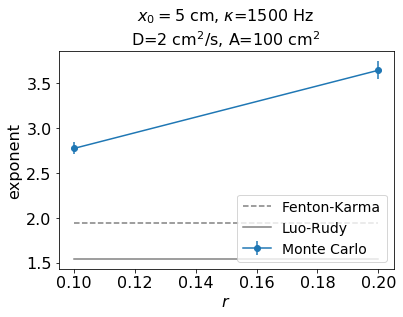

considering 0.3<q<0.6


In [403]:
m_fk=1.945#1.858;#+-0.027; B_fk=2.464+-0.030<br>
m_lr=1.544#1.638;#+-0.017; B_fk=5.588+-0.067
plt.errorbar(eg_lst, m_lst, yerr=Dm_lst, fmt='-o',label='Monte Carlo')
plt.plot(eg_lst, m_fk+0.*np.array(eg_lst), '--',c='gray',label='Fenton-Karma')
plt.plot(eg_lst, m_lr+0.*np.array(eg_lst), '-',c='gray',label='Luo-Rudy')

# plt.scatter(Dtdt_lst,m_lst,marker='^')
# plt.xscale('log')
title=f"$x_0=$"+f"{x0:.0f} cm, "+r"$\kappa$="+f"{kappa:.0f} Hz\nD={D} cm"+r"$^2$/s"+f", A={L**2:.0f} cm"+r"$^2$"
plt.title(title,fontsize=fontsize)
plt.xlabel(r'$r$',fontsize=fontsize)
plt.ylabel('exponent',fontsize=fontsize)
# plt.xscale('log')
# plt.yscale('log')
plt.tick_params(axis='both', which='major', labelsize=fontsize)
plt.tick_params(axis='both', which='minor', labelsize=0)
# plt.legend(fontsize=fontsize-8)#,ncol=2)
# plt.xlim([10,50])
# plt.ylim([0.9,2.3])
# plt.grid('on')
plt.legend(fontsize=fontsize-2,loc='lower right')
plt.show()
# print("considering 20<N<50 spiral tips")
# print("considering N<20 spiral tips")
print(f"considering {q_min}<q<{q_max}")

In [373]:
print('trials with case 3 and r=0.4 that finished')
print(f'kappa:{set(df[(df.varkappa<0)&(df.r==0.4)&(df.x0>0)].kappa.values)}')
print(f'D:{set(df[(df.varkappa<0)&(df.r==0.4)].D.values)}')
print(f"however, ^these trials did not finish when r=0.1...")

trials with case 3 and r=0.4 that finished
kappa:{100}
D:{2, 20}
however, ^these trials did not finish when r=0.1...


# TODO: make the standard 2 panel figure for 1 token control trial
- Control: varkappa<0, x0=0

# TODO: make the standard 2 panel figure
 for each nontrivial case
 - Case 1: varkappa>0, x0=0
 - Case 2: varkappa>0, x0>0
 - Case 3: varkappa<0, x0>0
 
 
 Consider Panel 
 A = Control
 BCD

# TODO: compute the RMSE of each trial with the power fit of the full model, limiting sample to relevant particle number densities

# TODO: compute the change in mean CollRate as a result of turning on the forces (setting no_attraction from 1 to 0).

In [194]:
#TODO: groupby groups
groups=['r','D','L','kappa','varkappa','x0','A','no_repulsion']

#TODO:compute the rate change 
df.loc[df.no_attraction==0,'change_of_rate']=df[df.no_attraction==0]['CollRate']-df[df.no_attraction==1]['CollRate']
df.loc[df.no_attraction==1,'change_of_rate']=df[df.no_attraction==0]['CollRate']-df[df.no_attraction==1]['CollRate']

df.sort_values(['r','D','L','kappa','varkappa','x0','A','no_repulsion'],inplace=True)

In [195]:
df.head()

,x0,varkappa,set_second,reflect,r,no_repulsion,no_attraction,kappa,dt,N,L,Dt,D,CollRate,A,q,w,change_of_rate
21185,0.5,-20,0,0,0.1,1,0,100,0.00001,6,10,0.00001,2,0.260860,100,0.06,0.002609,NaN
21186,0.5,-20,0,0,0.1,1,0,100,0.00001,7,10,0.00001,2,0.412341,100,0.07,0.004123,NaN
21187,0.5,-20,0,0,0.1,1,0,100,0.00001,8,10,0.00001,2,0.663055,100,0.08,0.006631,NaN
21188,0.5,-20,0,0,0.1,1,0,100,0.00001,9,10,0.00001,2,0.923199,100,0.09,0.009232,NaN
21189,0.5,-20,0,0,0.1,1,0,100,0.00001,10,10,0.00001,2,1.211192,100,0.10,0.012112,NaN


DONE: genetic algorithm k-parents
    1. consider the k trials with RMSE for (i) the FK model and (ii) the LR model
    1. take random linear combinations of ^those parents, run them on the OSG, and then take the k best fits
    1. repeat until desired convergence is met
    1. repeat for various k, and visualize any (in)dependence of k
- DONE: find rough fit to initialize genetic algorithm


In [408]:
data_dir="/home/timothytyree/Documents/GitHub/bgmc/python/data/osg_output/run_10_all.csv"
df=pd.read_csv(data_dir)
assert not (df.CollRate<0).any()
df.head()

,x0,varkappa,set_second,reflect,r,no_repulsion,no_attraction,kappa,dt,N,L,Dt,D,CollRate
0,0.0,-20,0,0,0.1,1,0,500,0.00001,6,10,0.00001,2,0.284806
1,0.0,-20,0,0,0.1,1,0,500,0.00001,6,10,0.00001,20,0.762509
2,0.0,-20,0,0,0.1,1,0,500,0.00001,7,10,0.00001,2,0.538927
3,0.0,-20,0,0,0.1,1,0,500,0.00001,7,10,0.00001,20,1.261349
4,0.0,-20,0,0,0.1,1,0,500,0.00001,8,10,0.00001,2,0.783767


In [409]:
#derived values
# df['CollRate']=1./df['CollTime']
df['A']=df['L']**2
df['q']=df['N']/df['A'] #number of tips per square centimeter
df['w']=df['CollRate']/df['A'] #[mHz?]/cm^2

# df=df[df.niter==250].copy()
#extract column values
r_values=np.array(sorted(set(df.r.values)))#cm
D_values=np.array(sorted(set(df.D.values)))#cm^2/s
L_values=np.array(sorted(set(df.L.values)))#cm
A_values=L_values**2#cm^2
kappa_values=np.array(sorted(set(df.kappa.values)))#1/s
varkappa_values=np.array(sorted(set(df.varkappa.values)))#1/s
x0_values=np.array(sorted(set(df.x0.values)))#1/s
set_second_values=np.array(sorted(set(df.set_second.values)))
reflect_values=np.array(sorted(set(df.reflect.values)))
no_repulsion_values=np.array(sorted(set(df.no_repulsion.values)))
no_attraction_values=np.array(sorted(set(df.no_attraction.values)))

In [410]:
#make test for whether there is one input parameter present in an input DataFrame1
print(r_values)
print(D_values)
print(L_values)
print(kappa_values)
print(varkappa_values)
print(x0_values)
print(set_second_values)
print(reflect_values)
print(no_repulsion_values)
print(no_attraction_values)

[0.1 0.2 0.3 0.4]
[ 2 20]
[10]
[ 100  500 1500]
[-20 -10  -5   0   5  10  20]
[0.  0.5 1.  1.5 2.  3.  4.  5. ]
[0]
[0]
[1]
[0 1]


In [412]:
varkappa=varkappa_values[0];print(f'varkappa={varkappa}')
x0=x0_values[2];print(f'x0={x0}')
#query the DataFrame
query =(df.set_second==set_second_values[0])&(df.reflect==reflect_values[0])
query&=df.r==r_values[0]
query&=df.D==D_values[0]
query&=df.L==L_values[0]
query&=df.varkappa==varkappa
query&=df.x0==x0
query&=(df.no_repulsion==no_repulsion_values[0])&(df.no_attraction==no_attraction_values[0])
dff=df[query]
kappa_values=np.array(sorted(set(dff.kappa.values)))
dg=dff[dff.kappa==kappa_values[0]]#smaller reaction rate
# dg=dff[dff.kappa==kappa_values[-1]]#Luo-Rudy fit
# dg=dff.kappa==kappa_values[0]#Fenton-Karma fit
x_values_force=dg.q.values
y_values_force=dg.w.values

varkappa=varkappa_values[3];print(f'varkappa={varkappa}')
x0=x0_values[2];print(f'x0={x0}')
#query the DataFrame
query =(df.set_second==set_second_values[0])&(df.reflect==reflect_values[0])
query&=df.r==r_values[0]
query&=df.D==D_values[0]
query&=df.L==L_values[0]
query&=df.varkappa==varkappa
query&=df.x0==x0
query&=(df.no_repulsion==no_repulsion_values[0])&(df.no_attraction==no_attraction_values[0])
dff=df[query]
kappa_values=np.array(sorted(set(dff.kappa.values)))
dg=dff[dff.kappa==kappa_values[0]]#smaller reaction rate
# dg=dff[dff.kappa==kappa_values[-1]]#Luo-Rudy fit
# dg=dff.kappa==kappa_values[0]#Fenton-Karma fit
x_values=dg.q.values
y_values=dg.w.values

varkappa=-20
x0=1.0
varkappa=0
x0=1.0


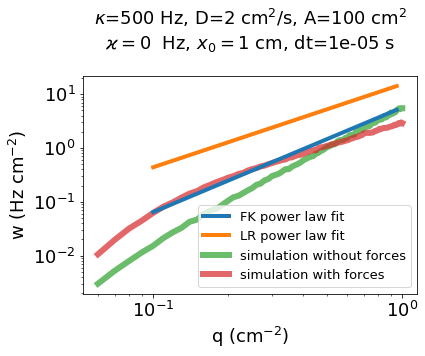

In [447]:
dt=1e-5
#plot fits for full model
m_fk=1.945;#+-0.030; B_fk=2.441+-0.051
m_lr=1.544;#+-0.034; B_lr=5.870+-0.137
M_fk=5.67;#+-0.39 Hz*cm^{2(m-1)}
M_lr=15.37;#+-1.57 Hz*cm^{2(m-1)}
# RMSE_fk=0.1252 Hz/cm^2
# RMSE_lr=0.0974 Hz/cm^2
# R^2=0.997 (FK)
# R^2=0.994 (LR)
# yscale=10**3
xv=np.arange(0.1,1.,.05)
yv_fk=M_fk*(xv)**m_fk
yv_lr=M_lr*(xv)**m_lr

fontsize=16
# plt.xlim([0.1,1])
# plt.ylim([1e-1,15])
plt.yscale('log')
plt.xscale('log')
plt.plot(xv,yv_fk,label='FK power law fit',zorder=3,lw=4)
plt.plot(xv,yv_lr,label='LR power law fit',zorder=3,lw=4)



fontsize=18
plt.plot(x_values,y_values,c='C2',alpha=.7,label='simulation without forces',lw=6)
plt.plot(x_values_force,y_values_force,c='C3',alpha=.7,label='simulation with forces',lw=6)
# plt.plot(x_values,y_values,c=c_values,alpha=0.4,cmap='bwr')
# plt.title(u'comparison to simulation\nwith two hybrid modes',fontsize=fontsize)
plt.xlabel(r'q (cm$^{-2}$)',fontsize=fontsize)
plt.ylabel(r'w (Hz cm$^{-2}$)', fontsize=fontsize)
plt.tick_params(axis='both', which='major', labelsize=fontsize)
plt.tick_params(axis='both', which='minor', labelsize=0)
plt.legend(fontsize=fontsize-5)
# print(f'varkappa={varkappa}  Hz');print(f'      x0={x0} cm')
title=r"$\kappa$="+f"{kappa:.0f} Hz, D={D} cm"+r"$^2$/s"+f", A={L**2:.0f} cm"+r"$^2$"
title+='\n'+r'$\varkappa=$'+f'{varkappa}  Hz, '+r'$x_0=$'+f'{x0:.0f} cm, dt={dt} s\n'
plt.title(title,fontsize=fontsize)

plt.title(title,fontsize=fontsize)
plt.show()

In [419]:
print(sorted(set(dg.r.values)))
print(sorted(set(dg.D.values)))
print(sorted(set(dg.L.values)))
print(sorted(set(dg.kappa.values)))

[0.1]
[2]
[10]
[500]


In [435]:
#import previous data
# data_dir="/home/timothytyree/Documents/GitHub/bgmc/python/data/osg_output/run_1_to_3_merged.csv" 
# data_dir="/home/timothytyree/Documents/GitHub/bgmc/python/data/osg_output/run_6_all.csv" # has match but dt=1e-5...
#Is it present in run_4??
df=pd.read_csv(data_dir)
assert not (df.CollRate<0).any()
#derived values
df['CollRate']=1./df['CollTime']
df['A']=df['L']**2
df['q']=df['N']/df['A'] #number of tips per square centimeter
df['w']=df['CollRate']/df['A'] #[mHz?]/cm^2

# # df=df[df.niter==250].copy()
# #extract column values
# r_values=np.array(sorted(set(df.r.values)))#cm
# D_values=np.array(sorted(set(df.D.values)))#cm^2/s
# L_values=np.array(sorted(set(df.L.values)))#cm
# A_values=L_values**2#cm^2
# kappa_values=np.array(sorted(set(df.kappa.values)))#1/s
# varkappa_values=np.array(sorted(set(df.varkappa.values)))#1/s
# x0_values=np.array(sorted(set(df.x0.values)))#1/s
# set_second_values=np.array(sorted(set(df.set_second.values)))
# reflect_values=np.array(sorted(set(df.reflect.values)))
# no_repulsion_values=np.array(sorted(set(df.no_repulsion.values)))
# no_attraction_values=np.array(sorted(set(df.no_attraction.values)))

#show the first 5 entries that match the query
query =df.r==r
query&=df.D==D
query&=df.L==L
query&=df.kappa==kappa
query&=df.reflect==reflect
dg=df[query]
dg.head()

AttributeError: 'DataFrame' object has no attribute 'CollRate'

In [428]:
dt_values=np.array(sorted(set(dg.dt.values)))
dt_values

array([1.e-05])

In [436]:
df.head()

,5,6,7,8,9,10,11,12,13,14,...,65,66,67,68,69,r,D,L,kappa,dt
0,0.00007,0.00007,0.00007,0.00007,0.00007,0.00007,0.00007,0.00007,0.00007,0.00007,...,0.00007,0.00007,0.00007,0.00007,0.00007,0.3,0.2,15.8114,1000,0.00001
1,0.40660,0.40660,0.40660,0.40660,0.40660,0.40660,0.40660,0.40660,0.40660,0.40660,...,0.00029,0.00029,0.00029,0.00029,0.00029,0.3,0.2,15.8114,1000,0.00001
2,5.15927,5.15927,5.15927,5.15927,5.15927,5.15927,5.15927,5.15927,5.15927,5.15927,...,0.00979,0.00979,0.00979,0.00979,0.00979,0.3,0.2,15.8114,1000,0.00001
3,19.50541,13.01108,13.01108,13.01108,13.01108,0.47663,0.47663,0.47663,0.47663,0.47663,...,0.00329,0.00329,0.00329,0.00329,0.00329,0.3,0.2,15.8114,1000,0.00001
4,11.12850,5.89572,5.89572,5.89572,5.89572,1.87785,1.87785,0.07995,0.07995,0.07995,...,0.00028,0.00028,0.00028,0.00028,0.00028,0.3,0.2,15.8114,1000,0.00001


In [432]:
del dg 
del df

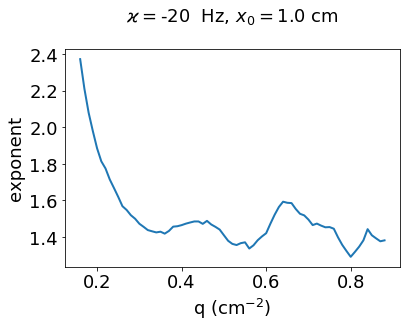

In [108]:
# #plot sliding m
# fontsize=18
# x=xavg_values[:-1]
# # y=Rsquared_values[:-1]
# y=slope_values[:-1]
# plt.plot(x,y,lw=2)
# # plt.scatter(x,y,s=10)
# # plt.xlabel('N',fontsize=fontsize)
# # plt.ylabel('Collision Rate',fontsize=fontsize)
# # plt.xscale('log')
# # plt.title(u'comparison to simulation\nwith two hybrid modes',fontsize=fontsize)
# plt.xlabel(r'q (cm$^{-2}$)',fontsize=fontsize)
# plt.ylabel(r'exponent', fontsize=fontsize)
# plt.tick_params(axis='both', which='major', labelsize=fontsize)
# plt.tick_params(axis='both', which='minor', labelsize=0)
# # print(f'varkappa={varkappa}  Hz');print(f'      x0={x0} cm')
# plt.title(r'$\varkappa=$'+f'{varkappa}  Hz, '+r'$x_0=$'+f'{x0} cm\n',fontsize=fontsize)
# plt.show()

In [421]:
# #measure m in some window
# qmin=0.06;qmax=0.2
# L=L_values[0]
# x_values=dg[dg.L==L].q.values
# y_values=dg[dg.L==L].w.values
# boo=(x_values>qmin)&(x_values<qmax)
# dict_ci=compute_95CI_ols(np.log(x_values[boo]),np.log(y_values[boo]))
# print(*dict_ci)
# print(*dict_ci.values())
# print(f"Therefore, 95% confidence interval DOES include exponent values observed from the Luo-Rudy model, but for this trial, only low densities.")

# #compute sliding m
# xavg_values,slope_values,Rsquared_values = compute_sliding_slope_loglog(x_values,y_values,    
#     x_min=qmin,
#     window_width=0.2,
#     stepsize=0.01,
# )
# xavg_values.shape

# sanity check from return_CollTime.x 
for probing the effect of dt at high density (q=1)

_This is evidence that attractive forces increase the collision rate, W, at high densities, which contradicts the figure I showed WJ and am looking at now._

...Then, why did I record a contradictory signal?

In [437]:
#I ran these settings without forces using ./return_CollTime.x for N=100
r=0.1
D=2
L=10
kappa=500
reflect=0

In [96]:
#from 1500 independent trials of the reaction N=100 --> N=98
#for each trial, seed=1234
#no forces
dt_control_lst=[1e-5, 1e-6, 1e-7]
Tavg_control_lst=[0.00175961,0.00172462,np.nan]
#strong attractive forces of close range
dt_lst=[1e-5, 1e-6, 1e-7]
Tavg_lst=[0.00102133,0.00104635,np.nan]
#NOTE: I ended the dt=1e-7 trials after 6 hours... They did not finish...

#is runtime on 1e-6 small enough for the OSG?
#no...

__Results__
- rate_with_force > rate_without_force at high densities when the seeds match
    - there is apparently a seed dependence to the value of Tavg
- it is not practical for me to use dt=1e-6 on the OSG.  It is certainly not practical for me to use dt=1e-7 on the OSG.
- it is necessary for seeds to match for the ends to match
    - Why is ^this? Is it because at high densities, q~1, the uncertainty is large for niter=1500?
- it is not necessary for seeds to match for the ends to match
    - TODO: just make niter=5000 on one machine(, or better...)
    - or aggregate many machines and make niter=15000
- solution: just make niter=5000 on the next data run, and limit search to trials in the neighborhood of where I think they'll model the LR model's powerfit


DONT: bootstrap uncertainties for variable N.  __Just increase niter!__
- I should measure the variance/95% CI explicitely versus N via bootstrapping for one trial. 
    - TODO: look for the/some token trial in the dense data from runs_1_to_3.
    - TODO: measure ^that trial's variance for each group of constant N
    - TODO: visualize the 95% CI of Tavg versus N.
    - TODO: translate ^that plot into w versus q


# print the top 5 of a given run, in terms of RMSE from the LR/FK models
then,
- use ^those to generate some guesses for the LR/FK models
then,
- dev run_11
then,
- condor_submit run_11.submit

## # Ranking the top results from the genetic algorithm
this is comparing rmse at high densities
compute w versus q and find r,kappa with smalles RMSE_lr,fk

In [23]:
# def routine(item):
#     r,D,kappa=item
#     return PlotUnivCurve(r,D,kappa)

# #run plotting in parallel
# b = db.from_sequence(queue, npartitions=9).map(routine)
# start = time.time()
# retval = list(b)
# print(f"run time was {time.time()-start:.2f} seconds.")
# beep(10)

In [417]:
def get_eval_powerlaw(dict_out):
    '''dict_out has fields m and b.
    
    Example Usage:
    eval_powerlaw=get_eval_powerlaw(dict_out)
    w=eval_powerlaw(q)
    '''
    m=dict_out['m'];b=dict_out['b']
    q_foo = lambda q: m*q+b
    eval_powerlaw = lambda q: np.exp(q_foo(np.log(q)))
    return eval_powerlaw

In [418]:
data_dir="/home/timothytyree/Documents/GitHub/bgmc/python/data/osg_output/run_12_all.csv"
df=pd.read_csv(data_dir)
df.head()

,x0,varkappa,set_second,reflect,r,no_repulsion,no_attraction,niter,neighbor,kappa,force_code,dt,N,L,Dt,D,CollRate
0,0,-20.0,0,0,0.1,1,0,1500,0,500,1,0.00001,6,10,0.00001,2,0.307259
1,0,-20.0,0,0,0.1,1,0,1500,0,500,1,0.00001,6,10,0.00001,20,0.781616
2,0,-20.0,0,0,0.1,1,0,1500,0,500,1,0.00001,7,10,0.00001,2,0.523640
3,0,-20.0,0,0,0.1,1,0,1500,0,500,1,0.00001,7,10,0.00001,20,1.282065
4,0,-20.0,0,0,0.1,1,0,1500,0,500,1,0.00001,8,10,0.00001,2,0.786102


In [419]:
df.columns

Index(['x0', 'varkappa', 'set_second', 'reflect', 'r', 'no_repulsion',
       'no_attraction', 'niter', 'neighbor', 'kappa', 'force_code', 'dt', 'N',
       'L', 'Dt', 'D', 'CollRate'],
      dtype='object')

In [420]:
(df.CollRate<0).any()

False

In [421]:
#derived values
# df['CollRate']=1./df['CollTime']
df['A']=df['L']**2
df['q']=df['N']/df['A'] #number of tips per square centimeter
df['w']=df['CollRate']/df['A'] #[mHz?]/cm^2

# df=df[df.niter==250].copy()
#extract column values
r_values=np.array(sorted(set(df.r.values)))#cm
D_values=np.array(sorted(set(df.D.values)))#cm^2/s
L_values=np.array(sorted(set(df.L.values)))#cm
A_values=L_values**2#cm^2
kappa_values=np.array(sorted(set(df.kappa.values)))#1/s
varkappa_values=np.array(sorted(set(df.varkappa.values)))#1/s
x0_values=np.array(sorted(set(df.x0.values)))#1/s
set_second_values=np.array(sorted(set(df.set_second.values)))
reflect_values=np.array(sorted(set(df.reflect.values)))
no_repulsion_values=np.array(sorted(set(df.no_repulsion.values)))
no_attraction_values=np.array(sorted(set(df.no_attraction.values)))

In [422]:
# #make test for whether there is one input parameter present in an input DataFrame1
# print(r_values)
# print(D_values)
# print(L_values)
# print(kappa_values)
# print(varkappa_values)
# print(x0_values)
# print(set_second_values)
# print(reflect_values)
# print(no_repulsion_values)
# print(no_attraction_values)

In [423]:


# r=r_values[0]
# L=L_values[0]
# D=2;#np.min(D_values);print(f'D={D}')
# varkappa=-20;#np.min(varkappa_values);print(f'varkappa={varkappa}')
# x0=1.;#np.max(x0_values);print(f'x0={x0}')
# # D==D_values[0];print(f'D={D}')
# # varkappa=varkappa_values[3];print(f'varkappa={varkappa}')
# # x0=x0_values[2];print(f'x0={x0}')
# #query the DataFrame
# query =(df.set_second==set_second_values[0])&(df.reflect==reflect_values[0])
# query&=df.r==r
# query&=df.D==D
# query&=df.L==L
# query&=df.varkappa==varkappa
# query&=df.x0==x0
# query&=(df.no_repulsion==no_repulsion_values[0])&(df.no_attraction==no_attraction_values[0])
# dff=df[query]
# kappa_values=np.array(sorted(set(dff.kappa.values)))
# dg=dff[dff.kappa==kappa_values[0]]#smaller reaction rate
# # dg=dff[dff.kappa==kappa_values[-1]]#Luo-Rudy fit
# # dg=dff.kappa==kappa_values[0]#Fenton-Karma fit

In [424]:
# varkappa=varkappa_values[3];print(f'varkappa={varkappa}')
# x0=x0_values[2];print(f'x0={x0}')
# #query the DataFrame
# query =(df.set_second==set_second_values[0])&(df.reflect==reflect_values[0])
# query&=df.r==r_values[0]
# query&=df.D==D_values[0]
# query&=df.L==L_values[0]
# query&=df.varkappa==varkappa
# query&=df.x0==x0
# query&=(df.no_repulsion==no_repulsion_values[0])&(df.no_attraction==no_attraction_values[0])
# dff=df[query]
# kappa_values=np.array(sorted(set(dff.kappa.values)))
# dg=dff[dff.kappa==kappa_values[0]].copy()#smaller reaction rate

In [425]:
#load birth death rates from the full model
data_folder=f'{nb_dir}/data'
os.chdir(data_folder)

data_fk_fn='full_results/data_fig4_vidmar_fk_tt.csv'
data_lr_fn='full_results/data_fig4_vidmar_lr_tt.csv'

fk=pd.read_csv(data_fk_fn)
fk['N']=fk['No2']*2
fk['q']=fk['N']/fk['A'] #number of tips per square centimeter
fk['w']=fk['rate']/fk['A'] #[mHz?]/cm^2

lr=pd.read_csv(data_lr_fn)
lr['N']=lr['No2']*2
lr['q']=lr['N']/lr['A'] #number of tips per square centimeter
lr['w']=lr['rate']/lr['A'] #[mHz?]/cm^2



In [426]:
#compute w_lr and w_fk using a linear regression of a log-log plot
# from lib.compute_slope import *
yscale=10**3
x=lr.q.values
y=yscale*lr.w.values
dict_out=compute_95CI_ols(np.log(x),np.log(y))
dict_lr=dict_out.copy()
#predict the values functionally over all q
m=dict_out['m'];b=dict_out['b']
q_foo = lambda q: m*q+b
df['w_lr']=np.exp(q_foo(np.log(df['q'].values)))

x=fk.q.values
y=yscale*fk.w.values
dict_out=compute_95CI_ols(np.log(x),np.log(y))
dict_fk=dict_out.copy()
#predict the values functionally over all q
m=dict_out['m'];b=dict_out['b']
q_foo = lambda q: m*q+b
df['w_fk']=np.exp(q_foo(np.log(df['q'].values)))

In [427]:
#compute the square errors 
df['se_w_fk']=(df['w']-df['w_fk'])**2
df['se_w_lr']=(df['w']-df['w_lr'])**2

In [428]:
# df_fn='w_vs_q_agg_over_A.csv'
# os.chdir(data_folder)
# df.to_csv(dg_fn,index=False)

In [429]:
#in rmse_lr,fk cell
qmin=0.3;qmax=1.0;
#compute the root mean squared errors over various axes
#common defines
no_attraction=0;no_repulsion=1;reflect=0;set_second=0
#input list
r_lst=[];D_lst=[];L_lst=[];kappa_lst=[];varkappa_lst=[];x0_lst=[]
neighbor_lst=[];force_code_lst=[]
varkappa_values=np.array(sorted(set(df.varkappa.values)))
#output list
rmse_lr_lst=[];rmse_fk_lst=[];m_lst=[];Delta_m_lst=[]
for set_second in set_second_values:
    for reflect in reflect_values:
        for r in r_values:
            for D in D_values:
                for L in L_values:
                    for kappa in kappa_values:
                        for varkappa in varkappa_values:
                            for x0 in x0_values:
                                for no_repulsion in no_repulsion_values:
                                    for no_attraction in no_attraction_values:
                                        for neighbor in neighbor_values:
                                            for force_code in force_code_values:
                                                #query the DataFrame
                                                query =(df.set_second==set_second)&(df.reflect==reflect)
                                                query&=df.r==r
                                                query&=df.D==D
                                                query&=df.L==L
                                                query&=df.kappa==kappa
                                                query&=df.varkappa==varkappa
                                                query&=df.x0==x0
                                                query&=(df.no_repulsion==no_repulsion)&(df.no_attraction==no_attraction)
                                                query&=(df.force_code==force_code)&(df.neighbor==neighbor)
                                                dg=df[query]
                                                #limit query to the specified interval of particle densities
                                                query=(dg.q>qmin)&(dg.q<qmax)
                                                qu=dg[query]
                                                # if the slice is non-empty
                                                if qu.size>0:
                                                    rmse_lr=np.sqrt(qu.se_w_lr.mean())
                                                    rmse_fk=np.sqrt(qu.se_w_fk.mean())
                                                    #extract the data
                                                    x_values=dg.q.values
                                                    y_values=dg.w.values
                                                    boo=(x_values>qmin)&(x_values<qmax)#redundant
                                                    try:
                                                        dict_ci=compute_95CI_ols(np.log(x_values[boo]),np.log(y_values[boo]))
                                                        #                             print(*zip(dict_ci,dict_ci.values()))
                                                        m=dict_ci['m']
                                                        Delta_m=dict_ci['Delta_m']                        
                                                    except AssertionError as e:
                                                        m=-9999
                                                        Delta_m=-9999                           
                                                    #record inputs
                                                    r_lst.append(r)
                                                    D_lst.append(D)
                                                    L_lst.append(L)
                                                    kappa_lst.append(kappa)
                                                    varkappa_lst.append(varkappa)
                                                    x0_lst.append(x0)
                                                    neighbor_lst.append(neighbor)
                                                    force_code_lst.append(force_code)
                                                    #record outputs
                                                    rmse_lr_lst.append(rmse_lr)
                                                    rmse_fk_lst.append(rmse_fk)   
                                                    m_lst.append(m)
                                                    Delta_m_lst.append(Delta_m)

In [430]:
beep(10)

0

In [431]:
#form a pandas.DataFrame of ^that
dh=pd.DataFrame({
    'rmse_lr':rmse_lr_lst,
    'rmse_fk':rmse_fk_lst,
    'm':m_lst,
    'Delta_m':Delta_m,
    'r':r_lst,
    'D':D_lst,
    'L':L_lst,
    'kappa':kappa_lst,
    'varkappa':varkappa_lst,
    'x0':x0_lst, 
    'neighbor':neighbor_lst,
    'force_code':force_code_lst, 
})
dh.head()

,rmse_lr,rmse_fk,m,Delta_m,r,D,L,kappa,varkappa,x0,neighbor,force_code
0,7.448599,0.333901,2.447971,0.02166,0.1,2,10,500,-20.0,0,0,1
1,7.426256,0.330097,2.458719,0.02166,0.1,2,10,500,-20.0,0,1,1
2,4.927409,2.312934,1.703322,0.02166,0.1,2,10,500,-20.0,1,0,1
3,5.072494,2.167726,1.708695,0.02166,0.1,2,10,500,-20.0,1,1,1
4,3.379839,10.360578,1.099381,0.02166,0.1,2,10,500,-20.0,5,0,1


In [436]:
#compute absolute error from the target exponent
dh['m_fk']=np.abs(dh['m']-m_fk)
dh['m_lr']=np.abs(dh['m']-m_lr)

In [437]:
#and the top 5 matches for either model is... (FK)
print(f"The top 5 for the Fenton-Karma model:")
dh.sort_values(by='rmse_fk').head(5)

The top 5 for the Fenton-Karma model:


,rmse_lr,rmse_fk,m,Delta_m,r,D,L,kappa,varkappa,x0,neighbor,force_code,m_fk,m_lr
247,7.200128,0.226445,2.290367,0.02166,0.1,2,10,500,5.0,0,1,3,0.345367,0.746367
38,7.320455,0.231302,2.303026,0.02166,0.1,2,10,500,5.0,0,1,3,0.358026,0.759026
34,7.163567,0.253647,2.293618,0.02166,0.1,2,10,500,1.0,0,1,3,0.348618,0.749618
27,7.337648,0.272561,2.404869,0.02166,0.1,2,10,500,0.1,0,0,2,0.459869,0.860869
28,7.250630,0.275988,2.398979,0.02166,0.1,2,10,500,0.1,0,0,3,0.453979,0.854979


In [438]:
#and the top 5 matches for either model is... (FK)
print(f"The top 5 for the Luo-Rudy model:")
dh.sort_values(by='rmse_lr',inplace=True)
dh.head(5)

The top 5 for the Luo-Rudy model:


,rmse_lr,rmse_fk,m,Delta_m,r,D,L,kappa,varkappa,x0,neighbor,force_code,m_fk,m_lr
147,0.508427,7.666471,1.542957,0.02166,0.1,20,10,500,20.0,0,0,2,0.402043,0.001043
39,0.543930,6.925783,1.487709,0.02166,0.1,2,10,500,10.0,0,0,2,0.457291,0.056291
149,0.673514,6.608440,1.587236,0.02166,0.1,20,10,500,20.0,0,1,2,0.357764,0.043236
359,0.681848,7.742419,1.458437,0.02166,0.1,20,10,500,20.0,0,1,2,0.486563,0.085563
41,0.786547,6.582102,1.456214,0.02166,0.1,2,10,500,10.0,0,1,2,0.488786,0.087786


In [439]:
#rank each trial by distance from m_fk
print(f"The top 5 for the exponent of the Fenton-Karma model:")
dh.sort_values(by='m_fk').head(5)

The top 5 for the exponent of the Fenton-Karma model:


,rmse_lr,rmse_fk,m,Delta_m,r,D,L,kappa,varkappa,x0,neighbor,force_code,m_fk,m_lr
314,5.235112,2.017382,1.948413,0.02166,0.1,20,10,500,-20.0,1,0,1,0.003413,0.404413
172,1.899622,8.993642,1.950208,0.02166,0.1,20,10,1500,-5.0,5,1,1,0.005208,0.406208
367,3.654284,10.825935,1.938239,0.02166,0.1,20,10,1500,-20.0,1,0,1,0.006761,0.394239
141,4.965076,2.291202,1.937195,0.02166,0.1,20,10,500,5.0,0,0,2,0.007805,0.393195
8,6.086469,1.164434,1.954083,0.02166,0.1,2,10,500,-10.0,1,0,1,0.009083,0.410083


In [440]:
#rank each trial by distance from m_lr
print(f"The top 5 for the exponent of the Luo-Rudy model:")
dh.sort_values(by='m_lr').head(5)

The top 5 for the exponent of the Luo-Rudy model:


,rmse_lr,rmse_fk,m,Delta_m,r,D,L,kappa,varkappa,x0,neighbor,force_code,m_fk,m_lr
147,0.508427,7.666471,1.542957,0.02166,0.1,20,10,500,20.0,0,0,2,0.402043,0.001043
160,7.944012,15.181191,1.549711,0.02166,0.1,20,10,1500,-20.0,5,1,1,0.395289,0.005711
62,5.279637,12.514453,1.550335,0.02166,0.1,2,10,1500,-10.0,5,1,1,0.394665,0.006335
61,5.553771,12.789959,1.537566,0.02166,0.1,2,10,1500,-10.0,5,0,1,0.407434,0.006434
96,13.628419,20.863749,1.536944,0.02166,0.1,2,10,1500,20.0,0,0,2,0.408056,0.007056


In [441]:
#save dh as csv
save_folder=f"{nb_dir}/data/osg_output"
assert ( os.path.exists(save_folder))
os.chdir(save_folder)
save_fn=data_dir.replace('.csv',f'run_12_rmse_m_lr_fk_qmin_{qmin}_qmax_{qmax}.csv')
dh.to_csv(save_fn,index=False)
assert(os.path.exists(save_fn))

In [442]:
set(dh.varkappa.values)

{-20.0, -10.0, -5.0, 0.0, 0.1, 1.0, 5.0, 10.0, 20.0, 50.0}

## DONE: dev run 11 using random linear combinations of ^those for the LR model 
-TODO(later): fork run 11 to fit the FK model.

In [260]:
# - DONE: make run 11 have niter=5000 and Nmax=60...
# num_trials_born=100 # the total number of daughters
# # print the breeding_values of the top 5 
# # num_breeders=5
# # num_breeding_params=3
# # breeding_cols=['D','varkappa','x0']
# # num_breeding_params=len(breeding_cols)
# # # taken from the *.ipynb located here: 'analyzing the effect of strong attractive forces between nearest neighbors.ipynb'
# # breeder_values=dh[breeding_cols].head(num_breeders).values
# # breeder_values_LR=breeder_values
# # print(breeder_values)
# #the top 5 for the LR model. Epoch 0
# breeder_values=np.array(
#     [[  2.,   -5.,    5. ],
#      [ 20.,   -5.,    5. ],
#      [ 20.,  -20.,    1.5],
#      [ 20.,  -10.,    3. ],
#      [  2.,  -20.,    1.5]])

# #breed the given most-fit trials omnisexually.
# num_breeders, num_breeding_params = breeder_values.shape
# rand_matrix=np.random.rand(num_trials_born-num_breeders,num_breeders) # each entry is uniformly distributed on the interval from 0 to 1.

# breeder_trials=np.matmul(rand_matrix,breeder_values)/num_breeders
# #prepend the breeding_values of the top 5 to breeder_trials
# trial_values=np.concatenate((breeder_values,breeder_trials),axis=0)
# for trial in trial_values:
#     D,varkappa,x0=trial
#     pass
# # trial_values.shape
# print ( (D,varkappa,x0))

## TODO(later): analyze ^those top 5-10 results by plotting them and paying a lot of attention to them...

In [446]:
#TODO: plot the best trial
#and the top 5 matches for either model is... (FK)
print(f"The top 5 for the Luo-Rudy model:")
dh.sort_values(by='m_lr',inplace=True)
dh.head(5)
#DONE: plot the corresponding control trial.  overlay with ^that
#DONE: plot the exponent versus q for the best trial and its control
#DONE: indicate the exponent of the LR model

The top 5 for the Luo-Rudy model:


,rmse_lr,rmse_fk,m,Delta_m,r,D,L,kappa,varkappa,x0,neighbor,force_code,m_fk,m_lr
147,0.508427,7.666471,1.542957,0.02166,0.1,20,10,500,20.0,0,0,2,0.402043,0.001043
160,7.944012,15.181191,1.549711,0.02166,0.1,20,10,1500,-20.0,5,1,1,0.395289,0.005711
62,5.279637,12.514453,1.550335,0.02166,0.1,2,10,1500,-10.0,5,1,1,0.394665,0.006335
61,5.553771,12.789959,1.537566,0.02166,0.1,2,10,1500,-10.0,5,0,1,0.407434,0.006434
96,13.628419,20.863749,1.536944,0.02166,0.1,2,10,1500,20.0,0,0,2,0.408056,0.007056


In [451]:
print(f"The top 5 for the Fenton-Karma model:")
dh.sort_values(by='m_fk',inplace=True)
dh.head(5)

The top 5 for the Fenton-Karma model:


,rmse_lr,rmse_fk,m,Delta_m,r,D,L,kappa,varkappa,x0,neighbor,force_code,m_fk,m_lr
314,5.235112,2.017382,1.948413,0.02166,0.1,20,10,500,-20.0,1,0,1,0.003413,0.404413
172,1.899622,8.993642,1.950208,0.02166,0.1,20,10,1500,-5.0,5,1,1,0.005208,0.406208
367,3.654284,10.825935,1.938239,0.02166,0.1,20,10,1500,-20.0,1,0,1,0.006761,0.394239
141,4.965076,2.291202,1.937195,0.02166,0.1,20,10,500,5.0,0,0,2,0.007805,0.393195
8,6.086469,1.164434,1.954083,0.02166,0.1,2,10,500,-10.0,1,0,1,0.009083,0.410083


In [452]:
arr=dh.head(5).values[:6,4:12]
# arr=np.array([
#     [1.0e-01, 2.0e+0, 1.0e+01, 1.5e+03, -5,5,0,1],
# #     [1.0e-01, 2.0e+0, 1.0e+01, 1.5e+03, -5,5,1,1],
#     [1.0e-01, 2.0e+0, 1.0e+01, 1.5e+03, 20,0,0,2],
#     [1.0e-01, 2.0e+0, 1.0e+01, 1.5e+03, 20,0,1,2],
#     [1.0e-01, 2.0e+0, 1.0e+01, 1.5e+03, 50,0,0,3],
#     [1.0e-01, 2.0e+0, 1.0e+01, 1.5e+03, 50,0,1,3],
# ])
for j in range(arr.shape[0]):
    r, D, L, kappa, varkappa, x0, neighbor, force_code = arr[j]

__Results__
- the best trials for the LR model have long ranges
- matching the seeds corrected the high density disagreement.

__Questions__
- did increasing niter fix the high density disagreement?

In [453]:
neighbor,force_code

(0.0, 1.0)

In [454]:
savefig_folder=f'{nb_dir}/../fig'
saving=True
for j in range(arr.shape[0]):
    reflect=0
    set_second=0
    no_repulsion=1
    L=10
    r, D, L, kappa, varkappa, x0,neighbor,force_code = arr[j] # #dh.head(5).values[j,4:12]
    savefig_fn=f'run_12_effect_of_attraction_r_{r:.1f}_D_{D:.2f}_L_{L:.0f}_kappa_{kappa:.0f}_varkappa_{varkappa:.2f}_x0_{x0:.2f}_neighbor_{int(neighbor):0d}_force_code_{int(force_code):0d}.png'
    print (*(r, D, L, kappa, varkappa, x0, neighbor, force_code))
    # r=0.1;D=20;L=10;kappa=1500;varkappa=-5;x0=5.

    #with forces
    #slice the df
    query =df.no_attraction==0
    query&=df.no_repulsion==no_repulsion
    query&=df.reflect==reflect
    query&=df.set_second==set_second
    query&=df.r==r
    query&=df.L==L
    query&=df.kappa==kappa
    dff=df[query]#.copy()
    #query the dataframe with the bred parameters
    query =dff.D==D
    query&=dff.varkappa==varkappa
    query&=dff.x0==x0
    query&=(dff.neighbor==int(neighbor))&(dff.force_code==int(force_code))
    dg=dff[query]#.copy() 
    #extract the data
    x_values_force=dg.q.values
    y_values_force=dg.w.values
    assert (y_values_force.shape[0]>0)###################
    
    #query the control
    #query the DataFrame
    query =(df.set_second==set_second)&(df.reflect==reflect)
    query&=df.r==r
    query&=df.D==D
    query&=df.L==L
    query&=df.kappa==kappa
    query&=df.varkappa==0
    query&=df.x0==0
    query&=(df.no_repulsion==no_repulsion)&(df.no_attraction==1)
    query&=(df.neighbor==0)&(df.force_code==0)
    dg=df[query]
    x_values=dg.q.values
    y_values=dg.w.values

    #slice relevant particle density to the particle densities observed from the full model
    qmin=0.1;qmax=1
    window_width=0.3
    stepsize=0.1
    try:
        boo=(x_values>qmin)&(x_values<qmax)
        dict_ci=compute_95CI_ols(np.log(x_values[boo]),np.log(y_values[boo]))
#         print(*zip(dict_ci,dict_ci.values()))
        #compute sliding m
        xavg_values,slope_values,Rsquared_values = compute_sliding_slope_loglog(x_values,y_values,    
            x_min=qmin,
            window_width=window_width,
            stepsize=stepsize,
        )
    except AssertionError as e:
        xavg_values,slope_values=np.array([]),np.array([])
        print ('uh-oh')

    #with forces
    boo=(x_values_force>qmin)&(x_values_force<qmax)
    dict_ci=compute_95CI_ols(np.log(x_values_force[boo]),np.log(y_values_force[boo]))
#     print(*zip(dict_ci,dict_ci.values()))
    #compute sliding m
    xavg_values_force,slope_values_force,Rsquared_values_force = compute_sliding_slope_loglog(x_values_force,y_values_force,    
        x_min=qmin,
        window_width=window_width,
        stepsize=stepsize,
    )
#     print((xavg_values.shape,xavg_values_force.shape))
    assert (xavg_values_force.shape[0]>0)

    #plot ^this trial against its control

    #plot fits for full model
    m_fk=1.945;#+-0.030; B_fk=2.441+-0.051
    m_lr=1.544;#+-0.034; B_lr=5.870+-0.137
    M_fk=5.67;#+-0.39 Hz*cm^{2(m-1)}
    M_lr=15.37;#+-1.57 Hz*cm^{2(m-1)}
    # RMSE_fk=0.1252 Hz/cm^2
    # RMSE_lr=0.0974 Hz/cm^2
    # R^2=0.997 (FK)
    # R^2=0.994 (LR)
    # yscale=10**3
    xv=np.arange(0.1,1.,.05)
    yv_fk=M_fk*(xv)**m_fk
    yv_lr=M_lr*(xv)**m_lr

    #plot the values
    figsize=(12,5)
    fontsize=16
    fig, axs = plt.subplots(ncols=2,figsize=figsize, constrained_layout=True)
    lw=3

    ax=axs[0]
    ax.plot(xv,yv_fk,label='Fenton-Karma',zorder=1,lw=lw,c='C0',alpha=.7)
    ax.plot(xv,yv_lr,label='Luo-Rudy',zorder=1,lw=lw,c='C1',alpha=.7)
    ax.plot(x_values,y_values,c='k',alpha=.7,label='without forces',lw=lw)
    ax.plot(x_values_force,y_values_force,c='C2',alpha=0.7,label='with forces',lw=lw)
    # plt.plot(x_values,y_values,c=c_values,alpha=0.4,cmap='bwr')
    # plt.title(u'comparison to simulation\nwith two hybrid modes',fontsize=fontsize)
    ax.set_xlabel(r'q (cm$^{-2}$)',fontsize=fontsize)
    ax.set_ylabel(r'w (Hz cm$^{-2}$)', fontsize=fontsize)
    ax.tick_params(axis='both', which='major', labelsize=fontsize)
    ax.tick_params(axis='both', which='minor', labelsize=0)
    ax.legend(fontsize=fontsize-2)
    # title=r'$D=$'+f'{D} cm'+r'$^2$/s, '+r'$\varkappa=$'+f'{varkappa}  Hz, '+r'$x_0=$'+f'{x0} cm\n'
    # ax.set_title(title,fontsize=fontsize)
    # plt.xlim([0.1,1])
    ax.set_ylim([2e-3,50])
    ax.set_yscale('log')
    ax.set_xscale('log')

    ax=axs[1]
    ax.plot(xavg_values,slope_values,lw=lw,c='k', label='without forces',alpha=.7)
    ax.plot(xavg_values_force,slope_values_force,lw=lw,c='C2', label='with forces',alpha=.7)
    ax.plot(xavg_values_force, m_fk+0.*xavg_values_force, '-',lw=lw,c='C0',label='Fenton-Karma',alpha=.7)
    ax.plot(xavg_values_force, m_lr+0.*xavg_values_force, '-',lw=lw,c='C1',label='Luo-Rudy',alpha=.7)
    # ax.set_xscale('log')
    ax.set_ylim([1.4,3])
    ax.set_xlabel(r'q (cm$^{-2}$)',fontsize=fontsize)
    ax.set_ylabel(r'exponent', fontsize=fontsize)
    ax.tick_params(axis='both', which='major', labelsize=fontsize)
    ax.tick_params(axis='both', which='minor', labelsize=0)
    # title=r'$D=$'+f'{D} cm'+r'$^2$/s, '+r'$\varkappa=$'+f'{varkappa}  Hz, '+r'$x_0=$'+f'{x0} cm\n'
    # title+=f"r={r:.1f} cm, "+r"$\kappa$="+f"{kappa:.0f} Hz, A={L**2:.0f} cm"+r"$^2$"+'\n'
    # ax.set_title(title,fontsize=fontsize)
    # ax.legend(loc='best',fontsize=fontsize-4,ncol=2)
    #format title
    title=r'$D=$'+f'{D:.0f} cm'+r'$^2$/s, '+r'$\varkappa=$'+f'{varkappa:.0f} Hz, '+r'$x_0=$'+f'{x0:.0f} cm\nforce_code={int(force_code)}, neighbors={int(neighbor)}\n'
#     title+=f"r={r:.1f} cm, "+r"$\kappa$="+f"{kappa:.0f} Hz, A={L**2:.0f} cm"+r"$^2$"+f'\n'#Rank = #{j+1}'
    title+=f"r={r:.1f} cm, "+r"$\kappa$="+f"{kappa:.0f} Hz, A={L**2:.0f} cm"+r"$^2$"+f'\nRank = #{j+1}'
    fig.suptitle(title, fontsize=fontsize+2)
    # fig.tight_layout()
    if not saving:
        plt.show()
    else:
        os.chdir(savefig_folder)
        plt.savefig(savefig_fn, dpi=300)
        print(f"saved figure in {savefig_fn}")
    plt.close()
beep(7)

0.1 20.0 10.0 500.0 -20.0 1.0 0.0 1.0
saved figure in run_12_effect_of_attraction_r_0.1_D_20.00_L_10_kappa_500_varkappa_-20.00_x0_1.00_neighbor_0_force_code_1.png
0.1 20.0 10.0 1500.0 -5.0 5.0 1.0 1.0
saved figure in run_12_effect_of_attraction_r_0.1_D_20.00_L_10_kappa_1500_varkappa_-5.00_x0_5.00_neighbor_1_force_code_1.png
0.1 20.0 10.0 1500.0 -20.0 1.0 0.0 1.0
saved figure in run_12_effect_of_attraction_r_0.1_D_20.00_L_10_kappa_1500_varkappa_-20.00_x0_1.00_neighbor_0_force_code_1.png
0.1 20.0 10.0 500.0 5.0 0.0 0.0 2.0
saved figure in run_12_effect_of_attraction_r_0.1_D_20.00_L_10_kappa_500_varkappa_5.00_x0_0.00_neighbor_0_force_code_2.png
0.1 2.0 10.0 500.0 -10.0 1.0 0.0 1.0
saved figure in run_12_effect_of_attraction_r_0.1_D_2.00_L_10_kappa_500_varkappa_-10.00_x0_1.00_neighbor_0_force_code_1.png


0

In [194]:
# # plot one of ^these trials against its control
# saving=False

# #plot fits for full model
# m_fk=1.945;#+-0.030; B_fk=2.441+-0.051
# m_lr=1.544;#+-0.034; B_lr=5.870+-0.137
# M_fk=5.67;#+-0.39 Hz*cm^{2(m-1)}
# M_lr=15.37;#+-1.57 Hz*cm^{2(m-1)}
# # RMSE_fk=0.1252 Hz/cm^2
# # RMSE_lr=0.0974 Hz/cm^2
# # R^2=0.997 (FK)
# # R^2=0.994 (LR)
# # yscale=10**3
# xv=np.arange(0.1,1.,.05)
# yv_fk=M_fk*(xv)**m_fk
# yv_lr=M_lr*(xv)**m_lr

# #plot the values
# figsize=(6,5)
# fontsize=16
# savefig_folder=f'{nb_dir}/../fig'
# savefig_fn=f'effect_of_attraction_D_{D:.0f}_varkappa_{varkappa:.0f}_x0_{x0:.0f}.png'
# fig, ax = plt.subplots(ncols=1,figsize=figsize)# ax=axs[1]
# lw=3


# ax.plot(xv,yv_fk,label='FK power law fit',zorder=1,lw=lw,c='C0',alpha=.7)
# ax.plot(xv,yv_lr,label='LR power law fit',zorder=1,lw=lw,c='C1',alpha=.7)
# ax.plot(x_values,y_values,c='k',alpha=.7,label='without forces',lw=lw)
# ax.plot(x_values_force,y_values_force,c='C2',alpha=0.7,label='with forces',lw=lw)
# # plt.plot(x_values,y_values,c=c_values,alpha=0.4,cmap='bwr')
# # plt.title(u'comparison to simulation\nwith two hybrid modes',fontsize=fontsize)
# ax.set_xlabel(r'q (cm$^{-2}$)',fontsize=fontsize)
# ax.set_ylabel(r'w (Hz cm$^{-2}$)', fontsize=fontsize)
# ax.tick_params(axis='both', which='major', labelsize=fontsize)
# ax.tick_params(axis='both', which='minor', labelsize=0)
# ax.legend(fontsize=fontsize-5)
# title=r'$D=$'+f'{D} cm'+r'$^2$/s, '+r'$\varkappa=$'+f'{varkappa}  Hz, '+r'$x_0=$'+f'{x0} cm\n'
# ax.set_title(title,fontsize=fontsize)
# # plt.xlim([0.1,1])
# # plt.ylim([1e-1,15])
# ax.set_yscale('log')
# ax.set_xscale('log')
# fig.tight_layout()
# if not saving:
#     plt.show()
# else:
#     plt.tight_layout()
#     os.chdir(savefig_folder)
#     plt.savefig(savefig_fn, dpi=300)
# #         print(f"saved figure in \n\t{savefig_fn}")
# #         plt.close()

In [ ]:
#DONT: abstract both plotting methods as functions
#DONE: merge ^these to plots quickly into one

In [ ]:
# m_fk=1.945#1.858;#+-0.027; B_fk=2.464+-0.030<br>
# m_lr=1.544#1.638;#+-0.017; B_fk=5.588+-0.067
# fontsize=16
# lw=3
# x=xavg_values[:-1]
# # y=Rsquared_values[:-1]
# y=slope_values[:-1]
# plt.plot(xavg_values,slope_values,lw=lw,c='k', label='without forces')
# plt.plot(xavg_values_force,slope_values_force,lw=lw,c='C2', label='with forces')
# plt.plot(xavg_values_force, m_fk+0.*xavg_values_force, '--',lw=lw,c='gray',label='Fenton-Karma')
# plt.plot(xavg_values_force, m_lr+0.*xavg_values_force, '-',lw=lw,c='gray',label='Luo-Rudy')
# # plt.scatter(x,y,s=10)
# # plt.xlabel('N',fontsize=fontsize)
# # plt.ylabel('Collision Rate',fontsize=fontsize)
# # plt.xscale('log')
# # plt.title(u'comparison to simulation\nwith two hybrid modes',fontsize=fontsize)
# plt.xlabel(r'q (cm$^{-2}$)',fontsize=fontsize)
# plt.ylabel(r'exponent', fontsize=fontsize)
# plt.tick_params(axis='both', which='major', labelsize=fontsize)
# plt.tick_params(axis='both', which='minor', labelsize=0)
# # print(f'varkappa={varkappa}  Hz');print(f'      x0={x0} cm')
# title=r'$D=$'+f'{D} cm'+r'$^2$/s, '+r'$\varkappa=$'+f'{varkappa}  Hz, '+r'$x_0=$'+f'{x0} cm\n'
# title+=f"r={r:.1f} cm, "+r"$\kappa$="+f"{kappa:.0f} Hz, A={L**2:.0f} cm"+r"$^2$"+'\n'
# plt.title(title,fontsize=fontsize)
# plt.legend(loc='best',fontsize=fontsize-4,ncol=2)
# plt.show()

In [37]:
#DONE: fix the y axes
#DONE(now): make ^those for 3 or so more trial settings
#TODO: assemble ^those in .odg on left side of one page
#TODO: on right side, take some Cornell notes.
#TODO(later): put all ^this into a function an automate the plotting of a given input csv that has only one trial in it.


In [245]:
#what are the varkappa values when force_code=2,3
set(df[df.force_code==3].varkappa.values)

{0.1, 1.0, 5.0, 10.0, 20.0, 50.0}

# TODO: show nearest=0,1 is not equivalent to machine precision

In [456]:
#token long-ranged forces
# force_code_values=np.array([2,3])
# no_attraction_values=np.array([0])
# neighbor_values=np.array([0,1])
# set_second_values=np.array([0])
# varkappa_values=np.array([0.1,1.,5.,10.,20.,50.])#1/s
# x0_values=np.array([0.])#,1.0,5.0])#cm #x0 does nothing for QED2,3
kappa=1500;no_attraction=0;force_code=1;neighbor=0;varkappa=-5;x0=5.
#query the DataFrame
query =(df.set_second==set_second)&(df.reflect==reflect)
query&=df.r==r
query&=df.D==D
query&=df.L==L
query&=df.kappa==kappa
query&=df.varkappa==varkappa
query&=df.x0==x0
query&=(df.no_repulsion==no_repulsion)&(df.no_attraction==no_attraction)
query&=(df.neighbor==neighbor)&(df.force_code==force_code)
dg=df[query]
x_values=dg.q.values
y_values=dg.w.values
x_values_force_neigh_0=x_values.copy()
y_values_force_neigh_0=y_values.copy()

neighbor=1
#query the DataFrame
query =(df.set_second==set_second)&(df.reflect==reflect)
query&=df.r==r
query&=df.D==D
query&=df.L==L
query&=df.kappa==kappa
query&=df.varkappa==varkappa
query&=df.x0==x0
query&=(df.no_repulsion==no_repulsion)&(df.no_attraction==no_attraction)
query&=(df.neighbor==neighbor)&(df.force_code==force_code)
dg=df[query]
x_values=dg.q.values
y_values=dg.w.values
x_values_force_neigh_1=x_values.copy()
y_values_force_neigh_1=y_values.copy()

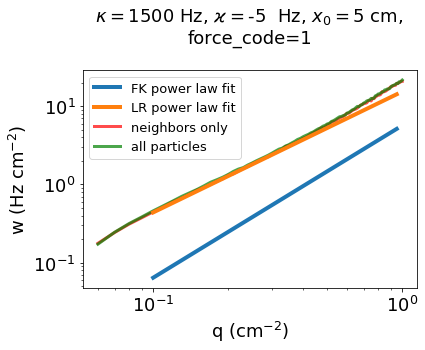

In [469]:
#plot fits for full model
m_fk=1.945;#+-0.030; B_fk=2.441+-0.051
m_lr=1.544;#+-0.034; B_lr=5.870+-0.137
M_fk=5.67;#+-0.39 Hz*cm^{2(m-1)}
M_lr=15.37;#+-1.57 Hz*cm^{2(m-1)}
# RMSE_fk=0.1252 Hz/cm^2
# RMSE_lr=0.0974 Hz/cm^2
# R^2=0.997 (FK)
# R^2=0.994 (LR)
# yscale=10**3
xv=np.arange(0.1,1.,.05)
yv_fk=M_fk*(xv)**m_fk
yv_lr=M_lr*(xv)**m_lr

fontsize=16
# plt.xlim([0.1,1])
# plt.ylim([1e-1,15])
plt.yscale('log')
plt.xscale('log')
plt.plot(xv,yv_fk,label='FK power law fit',zorder=3,lw=4)
plt.plot(xv,yv_lr,label='LR power law fit',zorder=3,lw=4,color='C1')

fontsize=18
plt.plot(x_values_force_neigh_1,y_values_force_neigh_1,'-',c='r',alpha=.7,label=r'neighbors only',lw=3)
plt.plot(x_values_force_neigh_0,y_values_force_neigh_0,'-',c='g',alpha=.7,label=r'all particles',lw=3)

# plt.plot(x_values,y_values,c='C2',alpha=.7,label='simulation',lw=6)
# plt.plot(x_values_force,y_values_force,c='C3',alpha=.7,label='simulation with forces',lw=6)
# plt.plot(x_values,y_values,c=c_values,alpha=0.4,cmap='bwr')
# plt.title(u'comparison to simulation\nwith two hybrid modes',fontsize=fontsize)
plt.xlabel(r'q (cm$^{-2}$)',fontsize=fontsize)
plt.ylabel(r'w (Hz cm$^{-2}$)', fontsize=fontsize)
plt.tick_params(axis='both', which='major', labelsize=fontsize)
plt.tick_params(axis='both', which='minor', labelsize=0)
plt.legend(fontsize=fontsize-5)
# plt.xlim([0.08,1])
# print(f'varkappa={varkappa}  Hz');print(f'      x0={x0} cm')
plt.title(r'$\kappa=1500$ Hz, $\varkappa=$'+f'{varkappa}  Hz, '+r'$x_0=$'+f'{x0:.0f} cm, '+f'\nforce_code={force_code}\n',fontsize=fontsize)
plt.show()

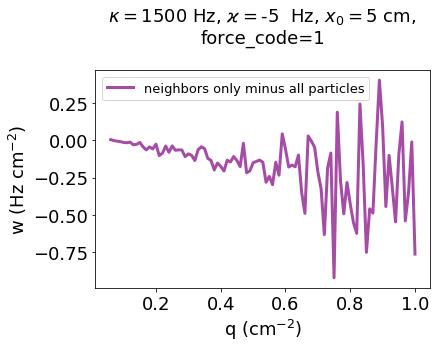

In [470]:
# plt.yscale('log')
# plt.xscale('log')
# plt.plot(xv,yv_fk,label='FK power law fit',zorder=3,lw=4)
# plt.plot(xv,yv_lr,label='LR power law fit',zorder=3,lw=4,color='C1')

fontsize=18
plt.plot(x_values_force_neigh_1,y_values_force_neigh_1-y_values_force_neigh_0,'-',c='purple',alpha=.7,label=r'neighbors only minus all particles',lw=3)

# plt.plot(x_values,y_values,c='C2',alpha=.7,label='simulation',lw=6)
# plt.plot(x_values_force,y_values_force,c='C3',alpha=.7,label='simulation with forces',lw=6)
# plt.plot(x_values,y_values,c=c_values,alpha=0.4,cmap='bwr')
# plt.title(u'comparison to simulation\nwith two hybrid modes',fontsize=fontsize)
plt.xlabel(r'q (cm$^{-2}$)',fontsize=fontsize)
plt.ylabel(r'w (Hz cm$^{-2}$)', fontsize=fontsize)
plt.tick_params(axis='both', which='major', labelsize=fontsize)
plt.tick_params(axis='both', which='minor', labelsize=0)
plt.legend(fontsize=fontsize-5)
# plt.xlim([0.08,1])
# print(f'varkappa={varkappa}  Hz');print(f'      x0={x0} cm')
plt.title(r'$\kappa=1500$ Hz, $\varkappa=$'+f'{varkappa}  Hz, '+r'$x_0=$'+f'{x0:.0f} cm, '+f'\nforce_code={force_code}\n',fontsize=fontsize)
plt.show()

NameError: name 'df' is not defined